In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import re
import io
import unicodedata
from tensorflow.keras.preprocessing import text as T
from tensorflow.keras.preprocessing import sequence as S
import tensorflow as tf
from random import shuffle
from tensorflow.keras.utils import to_categorical
import regex
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import random
from keras.utils import to_categorical
import os
import os.path
from os import path
from tensorflow.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image


## Preprocessing data:


In [2]:
# Create dataset
def create_dataset(path_zh, path_nushu, num_examples=None):
    nushu_sentences = io.open(path_nushu, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    
    chinese_sentences = ['<start> ' + s + ' <end>' for s in chinese_sentences[:num_examples]]
    
    print("Sample Nushu sentence (input):", nushu_sentences[0])  # Debug print
    print("Sample Chinese sentence (target):", chinese_sentences[0])  # Debug print
    
    return nushu_sentences[:num_examples], chinese_sentences[:num_examples]


# Tokenize the sentences
def tokenize(lang, num_words):
    lang_tokenizer = T.Tokenizer(num_words=num_words, filters='', oov_token='<UNK>')
    lang_tokenizer.fit_on_texts(lang)
    lang_tokenizer.word_index = {e: i for e, i in lang_tokenizer.word_index.items() if i <= lang_tokenizer.num_words}
    lang_tokenizer.index_word = dict(map(reversed, lang_tokenizer.word_index.items()))
    print("Word Index (sample):", dict(list(lang_tokenizer.word_index.items())[:10]))  # Debug print
    tensor = lang_tokenizer.texts_to_sequences(lang)
    print("Tokenized sequence (sample):", tensor[0])  # Debug print
    
    return tensor, lang_tokenizer


# Transform word to index
def load_dataset(path_to_file_nushu, path_to_file_zh, num_examples=None, num_words=80000):
    # Swap the order: Nushu sentences are now the input (inp_lang) and Chinese sentences are the target (targ_lang)
    inp_lang, targ_lang = create_dataset(path_to_file_nushu, path_to_file_zh, num_examples)
    
    # Tokenize the Nushu sentences (input) and Chinese sentences (target)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang, num_words * 2 if num_words else None)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang, num_words)
    
    # Ensure <start> and <end> tokens are in the target language tokenizer
    assert '<start>' in targ_lang_tokenizer.word_index, "Start token '<start>' is missing from the target language vocabulary!"
    assert '<end>' in targ_lang_tokenizer.word_index, "End token '<end>' is missing from the target language vocabulary!"
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


## Shuffle the data, define the batch generator

In [3]:
# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
def prepare_training_data(input_file_path):
    input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_file_path[0], input_file_path[1])
    print("Sample input tensor before shuffle:", input_tensor[0])  # Debug print
    print("Sample target tensor before shuffle:", target_tensor[0])  # Debug print
    input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
    print("Sample input tensor after shuffle:", input_tensor[0])  # Debug print
    print("Sample target tensor after shuffle:", target_tensor[0])  # Debug print

    # Creating training and validation sets using an 80-20 split
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

    # Input tokens for encoder/decoder zero padded
    num_encoder_tokens, num_decoder_tokens = len(inp_lang.index_word) + 1, len(targ_lang.index_word) + 1
    print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

    # Number of Training/validation samples
    N_train_samples = len(input_tensor_train)
    N_val_samples = len(input_tensor_val)
    print('Number of samples for Training/Validation: {}, {}'.format(N_train_samples, N_val_samples))
    
    # Max length of input/target sentences
    max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
    max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
    #max_length_inp = max_length_targ = 35 # Using a small max_length to truncat the sentence in order to reduce the memory consumption
    # 91% sentences have the length less than or euqel to 35 in Mircoblog set
    print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

    return input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, \
            inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens, \
            N_train_samples, N_val_samples, \
            max_length_inp, max_length_targ


def generate_batch(input_tensor, target_tensor, batch_size):
    while True:
        for i in range(0, min(len(input_tensor), (len(input_tensor)//batch_size)*batch_size), batch_size):
            encoder_input_batch = input_tensor[i:i + batch_size]
            encoder_input_batch = np.array(S.pad_sequences(
                encoder_input_batch, padding='post', maxlen=max_length_inp, truncating='post'
            ))
            print("Batch (sample):", encoder_input_batch[0])  # Debug print
            decoder_input_batch = target_tensor[i:i + batch_size]
            decoder_input_batch = np.array(S.pad_sequences(
                [s[:-1] for s in decoder_input_batch], padding='post', maxlen=max_length_targ, truncating='post'
            ))
            decoder_target_batch = target_tensor[i:i + batch_size]
            decoder_target_batch = np.array([
                to_categorical(t, len(targ_lang.word_index) + 1)
                for t in S.pad_sequences(
                    [s[1:] for s in decoder_target_batch], padding='post', maxlen=max_length_targ, truncating='post'
                )
            ])
            yield (encoder_input_batch, decoder_input_batch), decoder_target_batch



## Load the prepared data

In [4]:
input_file_path = ['chinese_598.tok', 'nushu_598.tok']

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, inp_lang, targ_lang, \
num_encoder_tokens, num_decoder_tokens, \
N_train_samples, N_val_samples, \
max_length_inp, max_length_targ = prepare_training_data(input_file_path)


Sample Nushu sentence (input): 𛆂 𛅽 𛈁 𛈍 𛉾
Sample Chinese sentence (target): <start> 文 化 多 样 性 <end>
Word Index (sample): {'<UNK>': 1, '𛈤': 2, '𛆳': 3, '𛆱': 4, '𛇏': 5, '𛅳': 6, '𛇁': 7, '𛈌': 8, '𛇈': 9, '𛆹': 10}
Tokenized sequence (sample): [170, 55, 77, 177, 144]
Word Index (sample): {'<UNK>': 1, '<start>': 2, '<end>': 3, '不': 4, '人': 5, '一': 6, '之': 7, '在': 8, '有': 9, '年': 10}
Tokenized sequence (sample): [2, 179, 490, 51, 633, 391, 3]
Sample input tensor before shuffle: [170, 55, 77, 177, 144]
Sample target tensor before shuffle: [2, 179, 490, 51, 633, 391, 3]
Sample input tensor after shuffle: [3, 37, 2, 75, 13, 37, 355, 36]
Sample target tensor after shuffle: [2, 4, 69, 166, 226, 6, 69, 1148, 18, 3]
Number of input tokens for encoder/decoder with zero padding: 374, 1453
Number of samples for Training/Validation: 478, 120
Max length of input/target sentences: 45, 46


## Get embedding matrix

In [5]:
# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
import gzip
import os
import tarfile
import wget
import os.path
from os import path
import numpy as np

def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(pre_trained_vector_paths, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(pre_trained_vector_paths)
    print('number of trained word vector: {}:{}'.format(pre_trained_vector_paths, len(trained_word_vec)))

    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def map_word_with_pretrained_word_embedding(pre_trained_vector_paths, word2index_inp, word2index_targ,\
                                            num_encoder_tokens, num_decoder_tokens, vector_size = 300):
    # Creating input embedding vectors
    input_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[0], word2index_inp, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[1], word2index_targ, vector_size, num_decoder_tokens)
    # Save output embedding vectors
    np.save(output_file_path[0], input_emb_matrix)
    np.save(output_file_path[1], output_emb_matrix)


In [6]:
# Train a FastText model for word-embedding
from gensim.models import FastText
import numpy as np

def get_embedding_matrix_from_fast_model(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))
    
    for word, idx in word2index.items():
        try:
            word_vec = fast_model.wv.word_vec(word)
        except KeyError:
              print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def train_fasttext_model(input_file_path, output_file_path, vector_size = 300):
    inps, targs  = create_dataset(input_file_path[0], input_file_path[1])
    tokens_zh = [[token for token in sents.split()] for sents in inps]
    tokens_en = [[token for token in sents.split()] for sents in targs]
    fast_model_zh = FastText(tokens_zh, vector_size=vector_size, window=10, min_count=5, sg=1, epochs=20, negative=10)
    fast_model_en = FastText(tokens_en, vector_size=vector_size, window=10, min_count=5, sg=1, epochs=20, negative=10)
    input_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)

    # Save output embedding vectors
    np.save(output_file_path[0] + "_trained", input_emb_matrix)
    np.save(output_file_path[1] + "_trained", output_emb_matrix)


In [7]:
def load_word_embedding(pre_trained_vector_paths, output_file_path, inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens):
    if not flag: 
        print("Using pre_trained FastText word_embedding :")
        download_fasttext_word_embedding(pre_trained_vector_paths)
        if not path.exists(output_file_path[0] + ".npy") or not path.exists(output_file_path[1] + ".npy"):
            map_word_with_pretrained_word_embedding(pre_trained_vector_paths, inp_lang.word_index, targ_lang.word_index, \
                                                    num_encoder_tokens, num_decoder_tokens)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + ".npy", output_file_path[1] + ".npy"))
        input_emb_matrix, output_emb_matrix = np.load(output_file_path[0] + ".npy"), np.load(output_file_path[1] + ".npy")
    else :
        print("Train a fasttext model to get word_embedding :")
        if not path.exists(output_file_path[0] + "_trained.npy") or not path.exists(output_file_path[1] + "_trained.npy"):
            train_fasttext_model(input_file_path, output_file_path)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + "_trained", output_file_path[1] + "_trained"))
        input_emb_matrix, output_emb_matrix= np.load(output_file_path[0] + "_trained.npy"), np.load(output_file_path[1] + "_trained.npy")

    print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

    return input_emb_matrix, output_emb_matrix


In [8]:
pre_trained_vector_paths = ['cc.zh.300.vec', 'cc.en.300.vec']

output_file_path = [
    'input_emb_matrix_598_iy.npy',  # To save the input embedding matrix
    'output_emb_matrix_598_iy.npy'  # To save the output embedding matrix
]


flag = 1 # 0 : using pre_trained word_embedding, 1 : train a fasttext model to get word_embedding
input_emb_matrix, output_emb_matrix = load_word_embedding(pre_trained_vector_paths, output_file_path,\
                                inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens)


Train a fasttext model to get word_embedding :
File  already exists : input_emb_matrix_598_iy.npy_trained, output_emb_matrix_598_iy.npy_trained
Embedding-matrix shape: (374, 300), (1453, 300)


In [9]:
from gensim.models import KeyedVectors
import numpy as np

# Load the pre-trained Chinese FastText vectors
pre_trained_vector_path_zh = 'cc.zh.300.vec'
zh_pretrained_vectors = KeyedVectors.load_word2vec_format(pre_trained_vector_path_zh, binary=False)

# Load your Chinese words from the tokenized file
with open('chinese598.tok', 'r', encoding='utf-8') as f:
    chinese_words = f.read().splitlines()  # Assuming one word per line

# Extract the embeddings for the Chinese words in your dataset
zh_word_embeddings = []
missing_words = []
for word in chinese_words:
    if word in zh_pretrained_vectors:
        zh_word_embeddings.append(zh_pretrained_vectors[word])
    else:
        missing_words.append(word)  # Track words that don't have embeddings

# Convert to numpy array
zh_word_embeddings = np.array(zh_word_embeddings)

# Save the extracted embeddings to a file
np.save('zh_pretrained_emb_iy.npy', zh_word_embeddings)

print(f"Saved {len(zh_word_embeddings)} word embeddings.")
if missing_words:
    print(f"Warning: {len(missing_words)} words were not found in the pre-trained vectors.")
    

Saved 0 word embeddings.


## Qualitative Semantic Analysis

Implement sample vector map + decoder:

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define the fonts for annotations
nushu_font = FontProperties(fname='NotoSansNushu-Regular.ttf')
chinese_font = FontProperties(fname='NotoSansSC-VariableFont_wght.ttf')

# Load the embedding matrices from the provided paths
input_emb_matrix = np.load('input_emb_matrix_598.npy_trained.npy')
output_emb_matrix = np.load('output_emb_matrix_598.npy_trained.npy')

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')

# Reduce dimensions for the embeddings (taking a subset of samples for speed)
tsne_results_nushu = tsne.fit_transform(input_emb_matrix[:342])
tsne_results_chinese = tsne.fit_transform(output_emb_matrix[:342])

# Reverse dictionaries for annotations
nushu_words = {v: k for k, v in inp_lang.word_index.items()}
chinese_words = {v: k for k, v in targ_lang.word_index.items()}

# Select random indices to annotate
nushu_indices_to_annotate = np.random.choice(range(300), 100, replace=False)
chinese_indices_to_annotate = np.random.choice(range(300), 100, replace=False)


FileNotFoundError: [Errno 2] No such file or directory: 'input_emb_matrix_598.npy_trained.npy'

In [ ]:
# # Plotting the results for Chinese embeddings with annotations
# plt.figure(figsize=(20, 8))

# plt.subplot(1, 2, 1)
# plt.scatter(tsne_results_chinese[:, 0], tsne_results_chinese[:, 1], alpha=0.5)
# for idx in chinese_indices_to_annotate:
#     plt.annotate(chinese_words.get(idx+1, 'unknown'), (tsne_results_chinese[idx, 0], tsne_results_chinese[idx, 1]), fontproperties=chinese_font)
# plt.title('t-SNE visualization of Chinese Embeddings with Annotations')

# # Save the plot as a file (change the filename and extension as needed)
# plt.savefig('chi_tsne.png', format='png', dpi=300)  # Save as PNG with high resolution

# # Display the plot
# plt.show()


In [ ]:
# # Plotting the results for Nushu embeddings with annotations
# plt.figure(figsize=(20, 8))

# plt.subplot(1, 2, 2)
# plt.scatter(tsne_results_nushu[:, 0], tsne_results_nushu[:, 1], alpha=0.5)
# for idx in nushu_indices_to_annotate:
#     plt.annotate(nushu_words.get(idx+1, 'unknown'), (tsne_results_nushu[idx, 0], tsne_results_nushu[idx, 1]), fontproperties=nushu_font)
# plt.title('t-SNE visualization of Nushu Embeddings with Annotations')

# # Save the plot as a file (change the filename and extension as needed)
# plt.savefig('nvshu_tsne.png', format='png', dpi=300)  # Save as PNG with high resolution

# plt.show()

## Silhouette Scores

In [11]:
# # Load dictionary
# df = pd.read_csv('data.csv')
# df.head()


In [12]:
# # Assuming the CSV file has two columns: 'Nushu' and 'Chinese'
# nushu_column = '女书字符'
# chinese_column = '对应汉字'

# # Split the Chinese column into individual characters
# df['Chinese_Characters'] = df[chinese_column].apply(list)

# # Display the dataframe to see the results
# df.head()


In [13]:
# # Create a dictionary where each Nushu word maps to a list of Chinese characters
# nushu_to_chinese_dict = dict(zip(df[nushu_column], df['Chinese_Characters']))

# # Example: Check the characters mapped to a specific Nushu word
# example_nushu = df[nushu_column].iloc[0]
# print(f'Nushu: {example_nushu}, Chinese Characters: {nushu_to_chinese_dict[example_nushu]}')


In [14]:
# # Re-importing necessary libraries
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties

# # Define the fonts for annotations
# nushu_font = FontProperties(fname='NotoSansNushu-Regular.ttf')
# chinese_font = FontProperties(fname='NotoSansSC-VariableFont_wght.ttf')

# # Load the embedding matrices from the provided paths
# input_emb_matrix = np.load('input_emb_matrix_442_new20.npy_trained.npy')
# output_emb_matrix = np.load('output_emb_matrix_442_new20.npy_trained.npy')


In [15]:
# # Use the existing word-to-index dictionaries for Nushu and Chinese words
# nushu_word_to_idx = inp_lang.word_index
# chinese_word_to_idx = targ_lang.word_index

# # Reverse dictionaries (already created)
# nushu_idx_to_word = {v: k for k, v in nushu_word_to_idx.items()}
# chinese_idx_to_word = {v: k for k, v in chinese_word_to_idx.items()}

# # Function to calculate cosine distance between two vectors
# def cosine_distance(vec1, vec2):
#     return 1 - np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# # Function to get embedding using reverse dictionary and word-to-index mappings
# def get_embedding_from_matrix(word, word_to_idx, emb_matrix):
#     idx = word_to_idx.get(word, None)  # Get index of the word
#     if idx is not None:
#         return emb_matrix[idx]
#     else:
#         return None  # If the word is not found, return None
    

In [16]:
# # Calculate cosine distances using the embedding matrices and reverse dictionaries
# cosine_distances = {}

# for nushu_word, chinese_words in nushu_to_chinese_dict.items():
#     nushu_embedding = get_embedding_from_matrix(nushu_word, nushu_word_to_idx, input_emb_matrix)
    
#     if nushu_embedding is not None:
#         distances = {}
#         for chinese_word in chinese_words:
#             chinese_embedding = get_embedding_from_matrix(chinese_word, chinese_word_to_idx, output_emb_matrix)
#             if chinese_embedding is not None:
#                 distance = cosine_distance(nushu_embedding, chinese_embedding)
#                 distances[chinese_word] = distance
        
#         cosine_distances[nushu_word] = distances


In [17]:
# # Example: Annotating output with actual Nushu and Chinese words
# for nushu_word, distances in cosine_distances.items():
#     print(f'Nushu word: {nushu_word}')
#     for chinese_word, distance in distances.items():
#         print(f'    Chinese word: {chinese_word}, Cosine Distance: {distance}')


In [18]:
# # Get the set of all Chinese words
# all_chinese_words = set(chinese_word_to_idx.keys())

# # Function to calculate Silhouette score with error handling
# def calculate_silhouette_score(nushu_word, related_chinese_words, cosine_distances, all_chinese_words):
#     # Check if the Nushu word has any cosine distances calculated
#     if nushu_word not in cosine_distances:
#         print(f"Skipping Nushu word {nushu_word} due to missing cosine distances.")
#         return None
    
#     # Get the distances for the related set
#     related_distances = [cosine_distances[nushu_word].get(chinese_word) for chinese_word in related_chinese_words if chinese_word in cosine_distances[nushu_word]]
#     if not related_distances:
#         print(f"Skipping Nushu word {nushu_word} due to missing related distances.")
#         return None
#     a_i = np.mean(related_distances)
    
#     # Get the distances for the irrelevant set (all Chinese words minus the related ones)
#     irrelevant_chinese_words = all_chinese_words - set(related_chinese_words)
#     irrelevant_distances = [
#         cosine_distance(get_embedding_from_matrix(nushu_word, nushu_word_to_idx, input_emb_matrix),
#                         get_embedding_from_matrix(chinese_word, chinese_word_to_idx, output_emb_matrix))
#         for chinese_word in irrelevant_chinese_words if get_embedding_from_matrix(chinese_word, chinese_word_to_idx, output_emb_matrix) is not None
#     ]
#     if not irrelevant_distances:
#         print(f"Skipping Nushu word {nushu_word} due to missing irrelevant distances.")
#         return None
#     b_i = np.mean(irrelevant_distances)
    
#     # Calculate Silhouette score
#     silhouette_score = (b_i - a_i) / max(a_i, b_i)
    
#     return silhouette_score


In [19]:
# # Calculate silhouette scores for all Nushu words
# silhouette_scores = {}

# for nushu_word, related_chinese_words in nushu_to_chinese_dict.items():
#     silhouette_score = calculate_silhouette_score(nushu_word, related_chinese_words, cosine_distances, all_chinese_words)
#     if silhouette_score is not None:
#         silhouette_scores[nushu_word] = silhouette_score

# # Extract highest and lowest scores for examination
# sorted_scores = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)


In [20]:
# # Top 3 highest scores
# print("Top 3 highest Silhouette scores:")
# for nushu_word, score in sorted_scores[:3]:
#     print(f'Nushu word: {nushu_word}, Silhouette Score: {score}')

# # Top 3 lowest scores
# print("\nTop 3 lowest Silhouette scores:")
# for nushu_word, score in sorted_scores[-3:]:
#     print(f'Nushu word: {nushu_word}, Silhouette Score: {score}')

# # Calculate the average Silhouette score for all Nushu characters
# average_silhouette_score = np.mean([score for score in silhouette_scores.values()])
# print(f"\nAverage Silhouette Score: {average_silhouette_score}")


## Built the Seq2seq model

In [21]:
!apt install graphviz
!pip install pydot pydot-ng

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



In [22]:
# AttentionLayer from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


def built_model(batch_size = 32, latent_dim = 300):
    # Set up the encoder
    encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
    enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
    enc_emb = enc_emb_layer(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    print('encoder_inputs/enc_emb shape: {}, {}'.format(encoder_inputs.shape, enc_emb.shape))
    encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
    encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
    # Embedding with with pre-trained embedding word vectors
    dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
    dec_emb = dec_emb_layer(decoder_inputs)
    # We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    print('decoder_inputs/dec_emb shape: {}, {}'.format(decoder_inputs.shape, dec_emb.shape))
    decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    # Concat attention input and decoder GRU output
    print('decoder_outputs/attn_out shape: {}, {}'.format(decoder_outputs.shape, attn_out.shape))
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    # Dense layer
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
    decoder_outputs = dense_time(decoder_concat_input)

    # Define the model that takes encoder and decoder input to output decoder_outputs
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    return enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model

encoder_inputs/enc_emb shape: (32, 45), (32, 45, 300)
decoder_inputs/dec_emb shape: (32, 46), (32, 46, 300)
decoder_outputs/attn_out shape: (32, 46, 600), (32, 46, 600)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (32, 45)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (32, 45, 300)     │    112,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (32, 46)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(32, 45, 600),   │  1,083,600 │ embedding[0][0]   │
│ (Bidirectional)     │ (32, 300), (32,   │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (32, 46, 300)     │    435,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (32, 600)         │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(32, 46, 600),   │  1,623,600 │ embedding_1[0][0… │
│                     │ (32, 600)]        │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(32, 46, 600),   │    720,600 │ bidirectional[0]… │
│ (AttentionLayer)    │ (32, 46, 45)]     │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (32, 46, 1200)    │          0 │ gru_1[0][0],      │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_l… │ (32, 46, 1453)    │  1,745,053 │ concat_layer[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,720,953 (21.82 MB)

 Trainable params: 5,172,853 (19.73 MB)

 Non-trainable params: 548,100 (2.09 MB)

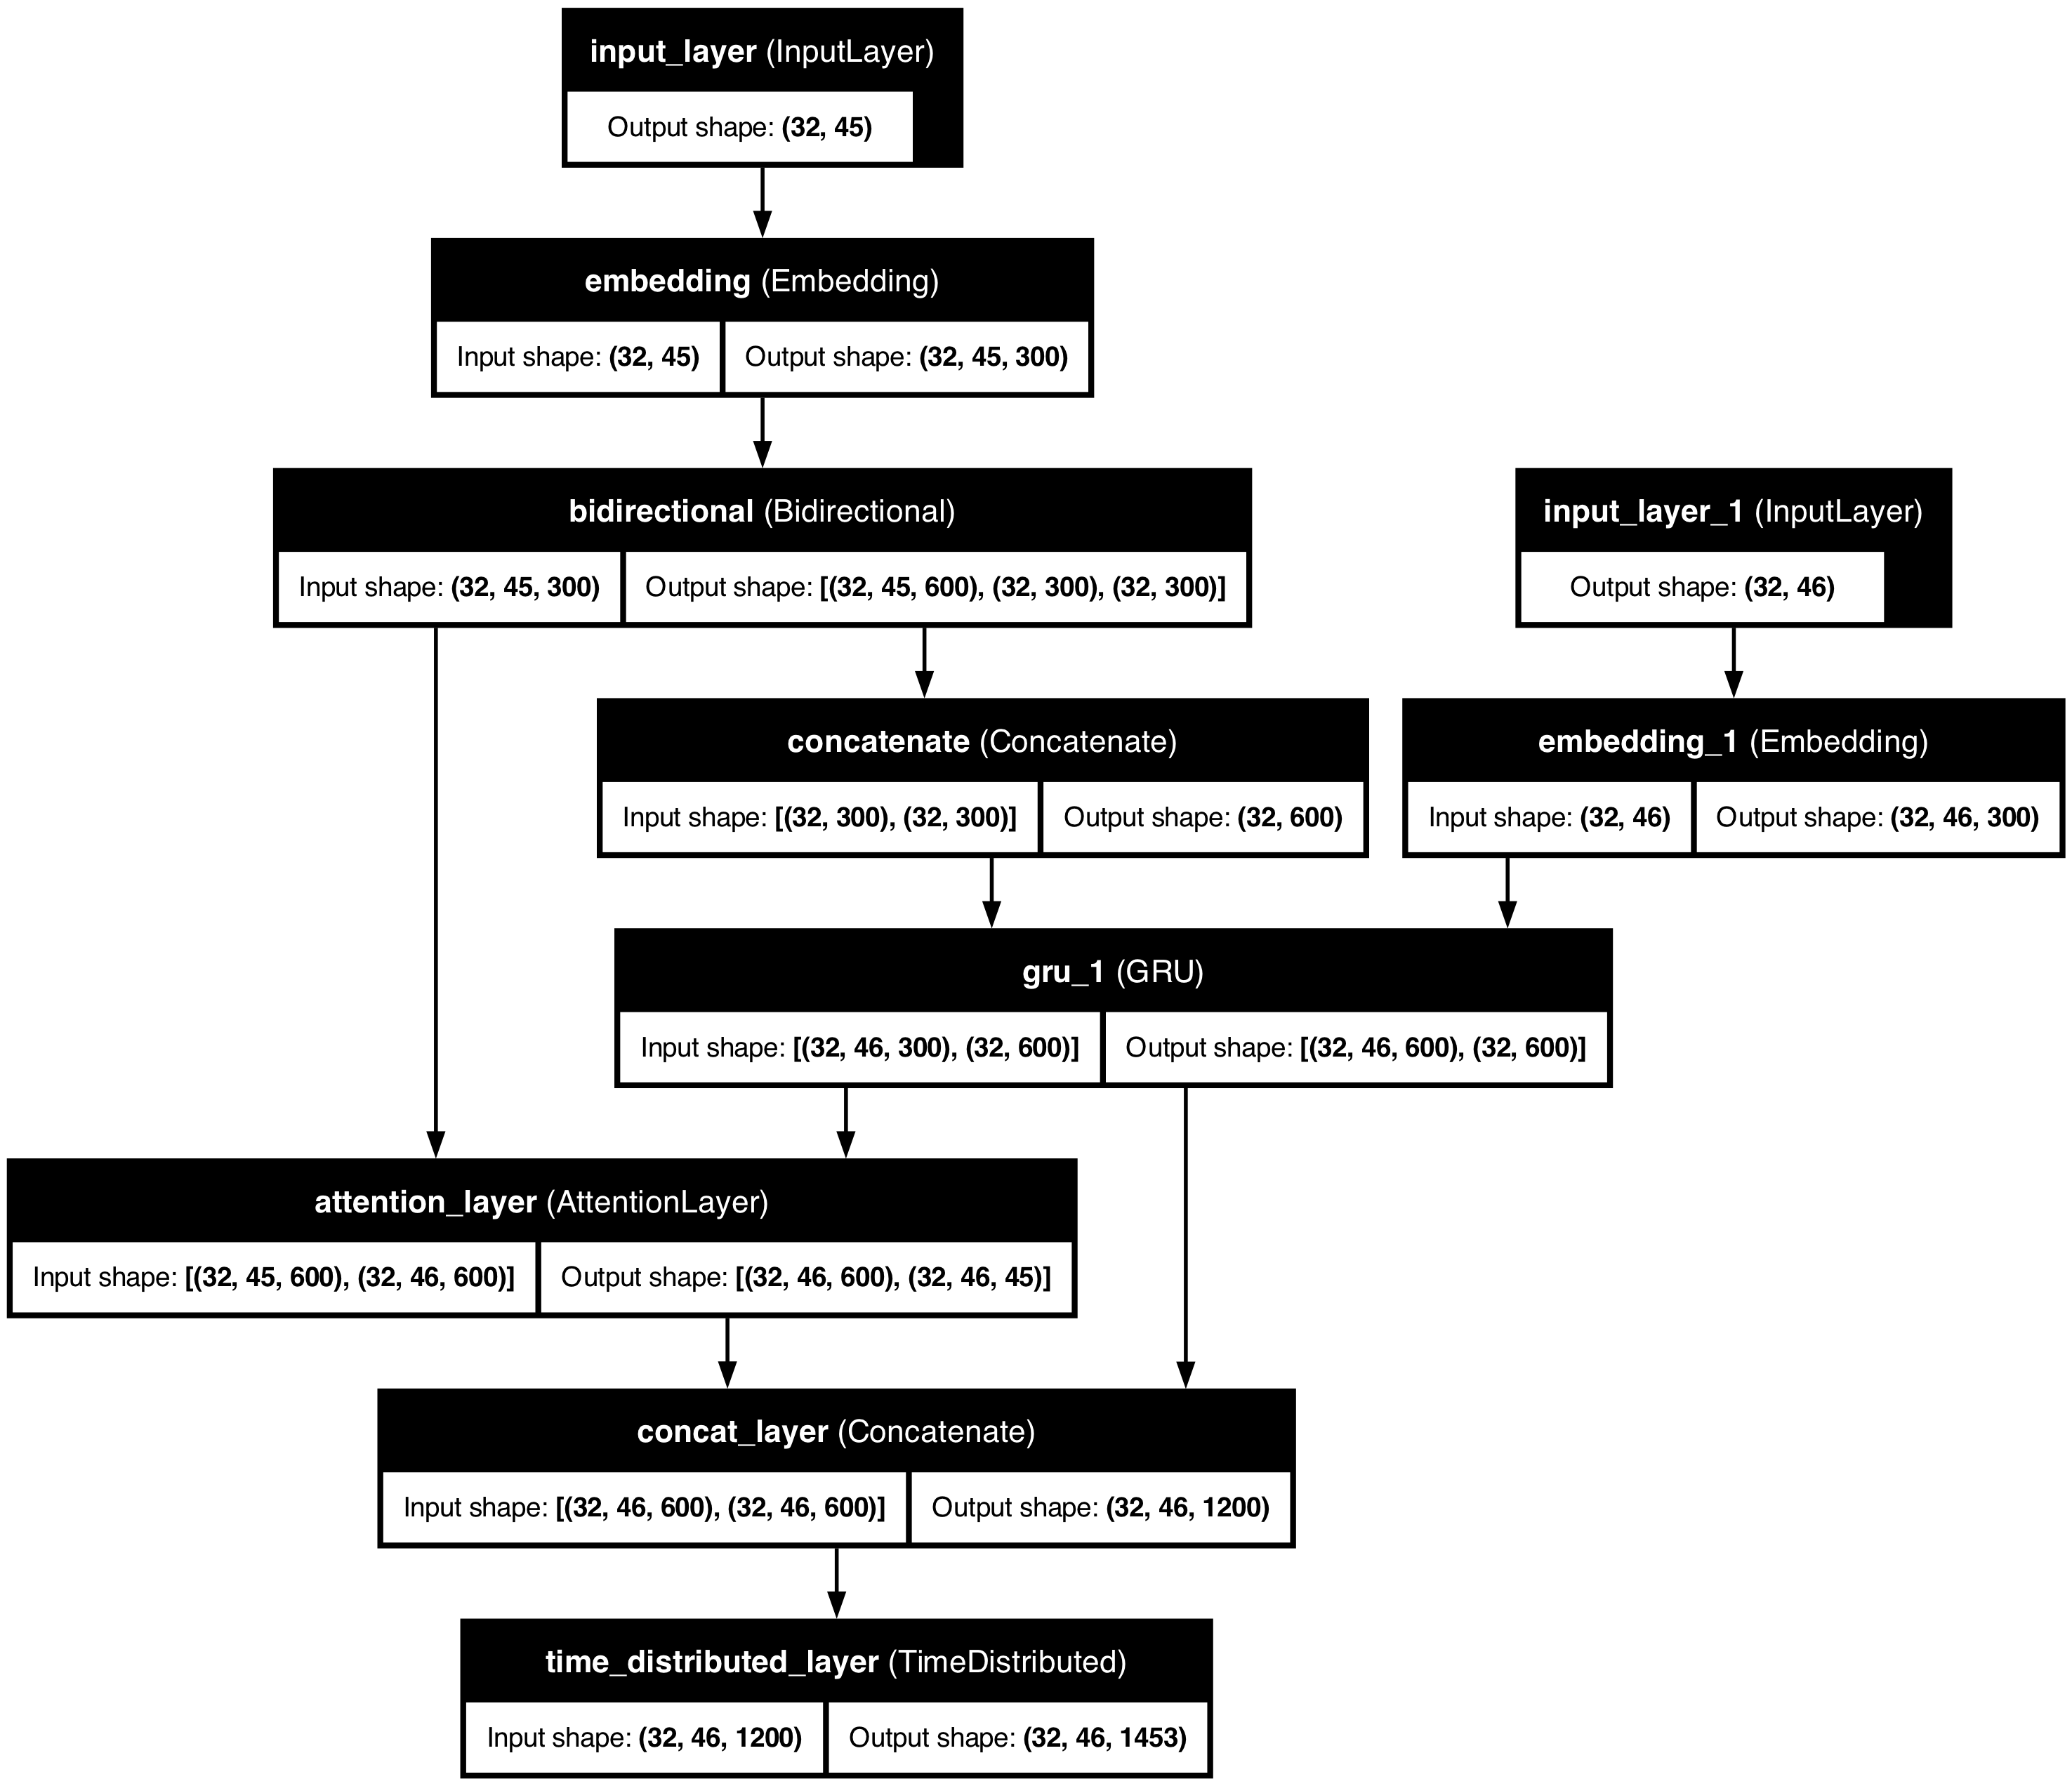

In [23]:
#__main()__
enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model = built_model(batch_size = 32, latent_dim = 300)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Train the model

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val,
                    N_train_samples, N_val_samples, batch_size=3, epochs=15):
    history = model.fit(
        generate_batch(input_tensor_train, target_tensor_train, batch_size=batch_size),
        steps_per_epoch=N_train_samples // batch_size,
        epochs=epochs,
        validation_data=generate_batch(input_tensor_val, target_tensor_val, batch_size=batch_size),
        validation_steps=N_val_samples // batch_size
    )
    return history


def plot_training_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(val_loss_values) + 1)

    plt.subplot(211)
    plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Test loss')
    plt.title('Training and val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Val accuracy')
    plt.title('Training and val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

Batch (sample): [  9  98 202  88   5  16 201 192 179  93  93 209 191 153   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [46  6 58 20  2 46 58 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Epoch 1/15
  1/159 ━━━━━━━━━━━━━━━━━━━━ 6:55 3s/step - acc: 0.0000e+00 - loss: 7.2934Batch (sample): [ 89  30  59  39  20 261  89 254   3  12  20 168   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  2/159 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - acc: 0.1866 - loss: 7.0825  Batch (sample): [270  21  27 217  16 155  71 197 151   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  3/159 ━━━━━━━━━━━━━━━━━━━━ 38s 246ms/step - acc: 0.2927 - loss: 6.8369Batch (sample):

 27/159 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - acc: 0.6478 - loss: 3.5729Batch (sample): [ 47  90 128  13  38 200  25 324  35 150  35  46  12  15   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 28/159 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - acc: 0.6506 - loss: 3.5319Batch (sample): [94 47 79  2 49 19 30  8 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 29/159 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - acc: 0.6532 - loss: 3.4930Batch (sample): [190 188 162  17  84  33 178 264 188  17  54 278  33 195   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 30/159 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - acc: 0.6557 - loss: 3.4561Batch (sample): [ 36  15   3  12  24 158  24  46   3  12   6  11   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

 54/159 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - acc: 0.6906 - loss: 2.9132Batch (sample): [ 50   9  39 107 121 189   7   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 55/159 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6914 - loss: 2.8993Batch (sample): [ 35 104 198 286 108  39  19  17 198 286 108  31 106   7  19  17  45   4
  49 304 168  17  12   6  39 322   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 56/159 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6923 - loss: 2.8855Batch (sample): [ 27  39  10 205  73 142  50 259  78 191 174  49  48  54   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 57/159 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - acc: 0.6930 - loss: 2.8724Batch (sample): [ 24  52 219  32   6 102 148  24 178 272 273  53 134  83   0   0   0   0
   0   0   0   0   0   

 81/159 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - acc: 0.7070 - loss: 2.6352Batch (sample): [146  47 217  26  20   8  16  44 217 241   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 82/159 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - acc: 0.7074 - loss: 2.6276Batch (sample): [ 46 117 173 106  59   2  44   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 83/159 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - acc: 0.7079 - loss: 2.6201Batch (sample): [124 241  53  45 137  81 199  81  68   9 294 122 108  53  28 160   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 84/159 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - acc: 0.7084 - loss: 2.6127Batch (sample): [100 160  47  52   8 249  17  65 179 218  14  54  22   0   0   0   0   0
   0   0   0   0   0   

108/159 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - acc: 0.7171 - loss: 2.4689Batch (sample): [35 56  9 15 17 32 55 55  6 73  4 12  6  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
109/159 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - acc: 0.7174 - loss: 2.4642Batch (sample): [ 39   6  13 291 163 109 190  84 142  60   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
110/159 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - acc: 0.7177 - loss: 2.4595Batch (sample): [101 179  61 155  10  61  51  89  20  95 193 314   3  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
111/159 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - acc: 0.7179 - loss: 2.4550Batch (sample): [231 164  13   2  73  67 158   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

135/159 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - acc: 0.7228 - loss: 2.3641Batch (sample): [109 225  20 102 110  49  23  47 122 168   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
136/159 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - acc: 0.7230 - loss: 2.3609Batch (sample): [ 54  36   3  55  97 102  98   3 134  40   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
137/159 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - acc: 0.7231 - loss: 2.3577Batch (sample): [151 152 166 166 278   4  85 278  97   4  85  21 153  97   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
138/159 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - acc: 0.7233 - loss: 2.3546Batch (sample): [221  50   7  96 202  83 238  10  39  15 121 140   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 30  88 145  48   2  40  56 203  58 163  51   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [119 155  29 192  67  33 156   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 13 268 230 154  97 121 142   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 30  42 213 213   5  34 250  20   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [155 155  41  41 254 254 215 215   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


  4/159 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - acc: 0.7489 - loss: 1.7260Batch (sample): [ 47 111  25  21  15 100 171  12  55  33   5  21  17 130  15   2  16  82
  23  79   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  5/159 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - acc: 0.7568 - loss: 1.6680Batch (sample): [ 50  36 196 196  57 244   4  10   6   7 122 182  26  44  83  20   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  6/159 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - acc: 0.7597 - loss: 1.6443Batch (sample): [ 13 114 287 287  55 214 260  18  45 171   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  7/159 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - acc: 0.7618 - loss: 1.6260Batch (sample): [ 81  20  13   8  54  30  17 133  92   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 31/159 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - acc: 0.7652 - loss: 1.5656Batch (sample): [ 84  88  19   6  91   9  11  54  48 268   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 32/159 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - acc: 0.7650 - loss: 1.5667Batch (sample): [350  16  69  42 184  31  18   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 33/159 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - acc: 0.7648 - loss: 1.5674Batch (sample): [100 156  24  25  24 216 178  43  32  24 141   7  24 180   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 34/159 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - acc: 0.7647 - loss: 1.5678Batch (sample): [ 78  63  79  33  34 240  37   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 58/159 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - acc: 0.7623 - loss: 1.5843Batch (sample): [  3  56  26  28 107 115 150   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 59/159 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - acc: 0.7622 - loss: 1.5850Batch (sample): [ 15 221 128  68 139  57 129   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 60/159 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - acc: 0.7621 - loss: 1.5856Batch (sample): [  3  45 142  69  86 137 276   2 150 113  19 164  95  27   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 61/159 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - acc: 0.7621 - loss: 1.5860Batch (sample): [268  11  50  14   8  23  45   5  95  68  50  14   5  51  14  50  51 271
 304  57  32  17  81  5

 85/159 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - acc: 0.7604 - loss: 1.5986Batch (sample): [ 11   9  38 248  11 113   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 86/159 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - acc: 0.7604 - loss: 1.5988Batch (sample): [144 334 247 283 220   7 224   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 87/159 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - acc: 0.7604 - loss: 1.5989Batch (sample): [ 82  18  20 132  74 107   3  46  44 217   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 88/159 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - acc: 0.7604 - loss: 1.5990Batch (sample): [ 74 117   3  59 171 142 191   3  59 192   0   0   0   0   0   0   0   0
   0   0   0   0   0   

112/159 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - acc: 0.7601 - loss: 1.6029Batch (sample): [147 130 208 131  73  49  32  57 284  36  55  62  10  63 214 119   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
113/159 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - acc: 0.7601 - loss: 1.6031Batch (sample): [  2  19  90   5   8  69 113   3  46 212   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
114/159 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - acc: 0.7600 - loss: 1.6034Batch (sample): [ 42 165   8 248 104 157 238 238 131 231   5  43  11  15   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
115/159 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - acc: 0.7600 - loss: 1.6036Batch (sample): [ 52  48  30  12  24  52 237  30  21 302  80  59  99   0   0   0   0   0
   0   0   0   0   0   

139/159 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - acc: 0.7591 - loss: 1.6101Batch (sample): [ 39 141  13  15 288 134 206 123  99  37  94   9 108   3  57 288  10  14
 160 113   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
140/159 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - acc: 0.7590 - loss: 1.6103Batch (sample): [113 178 183 180 280 138 229  81   7 170 284 161  29 249   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
141/159 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - acc: 0.7590 - loss: 1.6105Batch (sample): [165 103 236 134 112  80  15  12 117  10  12 167  81  26  31  27  12 167
  53  81 116  53  34 246  80 178   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
142/159 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - acc: 0.7590 - loss: 1.6108Batch (sample): [109  55   8  78 176   4  66 187 135 186   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 77  24  89  28  60 203  84   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 11  72 164  31 156 123  11 119  60  31 125 247   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 17 217   7  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [195  93 149   5   4  66 129   3 206 146  16 134 340 252   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 66  92 153  66  63  17 109  42 154   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


  9/159 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - acc: 0.7703 - loss: 1.5077Batch (sample): [ 86  16  61   6  31 151   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 10/159 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - acc: 0.7716 - loss: 1.4983Batch (sample): [ 24  33  18 143   4 138  21  11 100 155   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 11/159 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - acc: 0.7728 - loss: 1.4883Batch (sample): [245  82 263  32  99  14  35   6  53   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 12/159 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - acc: 0.7738 - loss: 1.4803Batch (sample): [192 181 139 152  86  16 236  39   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 36/159 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - acc: 0.7673 - loss: 1.5064Batch (sample): [  3 140  88   5  29 211  48   2 150 113  19  90   5   8   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 37/159 ━━━━━━━━━━━━━━━━━━━━ 31s 260ms/step - acc: 0.7672 - loss: 1.5068Batch (sample): [ 38 176  29  63 113  79 309 102 176 110 129  23  38 243   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 38/159 ━━━━━━━━━━━━━━━━━━━━ 31s 260ms/step - acc: 0.7671 - loss: 1.5072Batch (sample): [181  85  25  62  15 351 164  59 196  33   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 39/159 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - acc: 0.7669 - loss: 1.5078Batch (sample): [177   9  57  34 228 257 219  63   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 63/159 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - acc: 0.7644 - loss: 1.5196Batch (sample): [230  43  25 265 151 184  40  56 168  54 246   3  25  64   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 64/159 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - acc: 0.7643 - loss: 1.5200Batch (sample): [  6   5  57  57  11  20   4   8  14  35  35 137 121  20   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 65/159 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - acc: 0.7641 - loss: 1.5205Batch (sample): [138  74 120   8 245   3  71  34 240  29  17  42  25  21   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 66/159 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - acc: 0.7640 - loss: 1.5209Batch (sample): [190 176 190 182 190  58 211 264 176  65   4 178 138 120   0   0   0   0
   0   0   0   0   0   

 90/159 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - acc: 0.7628 - loss: 1.5231Batch (sample): [255 237  79 195  30   7 139  11  85  47   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 91/159 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - acc: 0.7628 - loss: 1.5229Batch (sample): [154  87  62 183  21 111  30  70  87  23  47 339 183  68   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 92/159 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - acc: 0.7628 - loss: 1.5228Batch (sample): [125  44  29 160 147  44 129 225   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 93/159 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - acc: 0.7627 - loss: 1.5226Batch (sample): [253  76  85  52 302  10 253  50 302   4  90   7  43  67 282 253  76  76
 302   0   0   0   0   

117/159 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - acc: 0.7622 - loss: 1.5220Batch (sample): [ 19  10 124  23  32 369   9  89  38  13  12  18  12  24   6  18   7  77
 107 326   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
118/159 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - acc: 0.7621 - loss: 1.5221Batch (sample): [306 120  63 172 133  28   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
119/159 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - acc: 0.7621 - loss: 1.5221Batch (sample): [103 137 199  49  21 106  34  38  96  79  42  29  99  25   2  38  96  29
  99  25  58 236  48 137  26 224  21  29  99  25  42  21  52  29  99  25
  42   4  21 125 373  42  43  45  13]
120/159 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - acc: 0.7621 - loss: 1.5221Batch (sample): [  9 149   8  40 143 163 261  54  21   8  30 112  12  95   0   0   0   0
   0   0   0   0   0   

144/159 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - acc: 0.7610 - loss: 1.5242Batch (sample): [ 13 164 309  67  38 161  40 136 243   9 136   3 165  64   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
145/159 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - acc: 0.7610 - loss: 1.5242Batch (sample): [ 11 173  60  17 104 125  14  12  95   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
146/159 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - acc: 0.7610 - loss: 1.5242Batch (sample): [101   6 128   9   3   8  26   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
147/159 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - acc: 0.7609 - loss: 1.5243Batch (sample): [210  64 224 224 100  88  45   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [155  56  74 136 360 128  74   6   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 38 125  11 102 125  50 273   7 152   6   5  66 148 175 125   7  69  46
 152   5  66   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [329  33 105  64  88 207 135  51  35  92 277  52  63 112   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [173 122 250  25 122  26   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [  3 208  22 280 156  22 163  20  25  41 250  93   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 15/159 ━━━━━━━━━━━━━━━━━━━━ 1:12:59 30s/step - acc: 0.7730 - loss: 1.3756Batch (sample): [ 78 152 244  11   8 165 239 111  56  78   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 16/159 ━━━━━━━━━━━━━━━━━━━━ 1:07:42 28s/step - acc: 0.7730 - loss: 1.3770Batch (sample): [ 94  47  27  31  45  19  30   8 177   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 17/159 ━━━━━━━━━━━━━━━━━━━━ 1:03:04 27s/step - acc: 0.7730 - loss: 1.3782Batch (sample): [ 29   9 241  86 223  13 103  96  22 115 207 189 239  78   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 18/159 ━━━━━━━━━━━━━━━━━━━━ 58:59 25s/step - acc: 0.7729 - loss: 1.3801  Batch (sample): [  8 106 344  23  15   5   4  23  11   2  74  58 233 170  15  25   0   0
   0   0   0   

 42/159 ━━━━━━━━━━━━━━━━━━━━ 20:41 11s/step - acc: 0.7675 - loss: 1.4126Batch (sample): [ 17 185   7  18 112  66 332  55 185  40 207 151  61 202   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 43/159 ━━━━━━━━━━━━━━━━━━━━ 20:02 10s/step - acc: 0.7674 - loss: 1.4130Batch (sample): [ 50  76  78  47  77  41 244  33 136  58   5 126 160   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 44/159 ━━━━━━━━━━━━━━━━━━━━ 19:24 10s/step - acc: 0.7674 - loss: 1.4132Batch (sample): [227  87  56  16 197  48  77 127  87  29 129 197  22  62   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 45/159 ━━━━━━━━━━━━━━━━━━━━ 18:49 10s/step - acc: 0.7673 - loss: 1.4135Batch (sample): [ 94 126  27  31 132 316 354  79   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 69/159 ━━━━━━━━━━━━━━━━━━━━ 9:44 6s/step - acc: 0.7652 - loss: 1.4205Batch (sample): [  2  23  24  21 111   6 163 203  48  77   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 70/159 ━━━━━━━━━━━━━━━━━━━━ 9:30 6s/step - acc: 0.7652 - loss: 1.4206Batch (sample): [ 81 352 157   9  60   2 297   5 130 331   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 71/159 ━━━━━━━━━━━━━━━━━━━━ 9:16 6s/step - acc: 0.7651 - loss: 1.4207Batch (sample): [ 57 353 223 201  63  79 242 184   9 150   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 72/159 ━━━━━━━━━━━━━━━━━━━━ 9:02 6s/step - acc: 0.7650 - loss: 1.4208Batch (sample): [192 181 139 152  20 169  18   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

 96/159 ━━━━━━━━━━━━━━━━━━━━ 4:57 5s/step - acc: 0.7646 - loss: 1.4167Batch (sample): [ 15 199  21 136   9  30  17 138 225  55  92   2 305 135  25  12  45  30
 342  14   9   9  97  74 287 255   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 97/159 ━━━━━━━━━━━━━━━━━━━━ 4:49 5s/step - acc: 0.7647 - loss: 1.4164Batch (sample): [193  27 100 118 110  69  32  73  23   8 120 227   9  25   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 98/159 ━━━━━━━━━━━━━━━━━━━━ 4:42 5s/step - acc: 0.7647 - loss: 1.4161Batch (sample): [170  55  77 177 144   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 99/159 ━━━━━━━━━━━━━━━━━━━━ 4:35 5s/step - acc: 0.7647 - loss: 1.4160Batch (sample): [13 35  2 98 19  4 54 13  9  2 98 19  4 78  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

123/159 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - acc: 0.7642 - loss: 1.4138Batch (sample): [  6   3  36  26  29  48 294  12  29   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
124/159 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - acc: 0.7641 - loss: 1.4139Batch (sample): [ 63  48  85  47 124 208 269   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
125/159 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - acc: 0.7641 - loss: 1.4139Batch (sample): [135  26  46 233 158  58 232  30   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
126/159 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - acc: 0.7641 - loss: 1.4139Batch (sample): [266 266  82  93  73  49  23  42 212  54   8  11  14  28   0   0   0   0
   0   0   0   0   0   0   0   

150/159 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - acc: 0.7633 - loss: 1.4133Batch (sample): [  2 116 232   4  21  45 222  18  59   4  44  44 154   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
151/159 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.7633 - loss: 1.4133Batch (sample): [ 6  3 46  9  3 43  3  7 86 16 26  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
152/159 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - acc: 0.7632 - loss: 1.4133Batch (sample): [185  33  25 299  14   4 197  14   4  21   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
153/159 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.7632 - loss: 1.4133Batch (sample): [  4 300  46 370  31   9   2  31 167  94  31  14 104  31  75  14   9   9
   3  59  31   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0

Batch (sample): [  4  72  60 120 151  34 221 151 126  24   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 63  90 297 227 148  20   2 118 130   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 79  29   3  10  59 116   9   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [  7 311   7 311  96 267 317  10   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 49 109  13  83  24  84  97 210  84 109 163  37 161 259   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 19/159 ━━━━━━━━━━━━━━━━━━━━ 34s 246ms/step - acc: 0.7755 - loss: 1.2305Batch (sample): [172 119  85  42   4  34  38 102  64  55 255  48  66  12   2  31   4 155
  56  26 172  12  74 282   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 20/159 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - acc: 0.7750 - loss: 1.2346Batch (sample): [ 13 188 152  81  17 249 127 188 152 164  84 201   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 21/159 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - acc: 0.7743 - loss: 1.2397Batch (sample): [ 57  25  17 209 112 145  80 127 153  41   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 22/159 ━━━━━━━━━━━━━━━━━━━━ 34s 249ms/step - acc: 0.7738 - loss: 1.2436Batch (sample): [180 191  28  14  65  68  55 100 251 167   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 46/159 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - acc: 0.7713 - loss: 1.2595Batch (sample): [ 43  97 137  28  14 193 174  72  50 202   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 47/159 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - acc: 0.7713 - loss: 1.2596Batch (sample): [198  10   8 273  85 301  74 346   6  50   6 365  74   2 148 187  33  70
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 48/159 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - acc: 0.7713 - loss: 1.2596Batch (sample): [136  64  33 266 262 174  78 161 161  40 134 265 211  25   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 49/159 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - acc: 0.7713 - loss: 1.2597Batch (sample): [106  53  49  30  87  27  30  87  13  27  49  53  37  27  30  87   4  27
  49  53  37  51  27   

 73/159 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - acc: 0.7698 - loss: 1.2640Batch (sample): [100   9   4   5 181  62 242  12 110  92   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 74/159 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - acc: 0.7698 - loss: 1.2640Batch (sample): [190  71  36  17 190  58 211 264  71  78 182 112  67  22   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 75/159 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - acc: 0.7697 - loss: 1.2638Batch (sample): [188   5   8  15   8   6   8  15  83 168  18  38  56  60 160  18  90  25
  38 170   2  20  38 170   2 320   7   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 76/159 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - acc: 0.7697 - loss: 1.2637Batch (sample): [267 249 314  67   4  74  98  11 281   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

100/159 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - acc: 0.7699 - loss: 1.2581Batch (sample): [ 97 296 133  41 330  42  20  19   6  32   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
101/159 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - acc: 0.7699 - loss: 1.2578Batch (sample): [367  12 158   5  23 304 108 271  31   6  28  49  50 108   6 187 215   2
  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
102/159 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - acc: 0.7699 - loss: 1.2576Batch (sample): [ 19 208 115 158 255  32  24  23  15   9  21 134  62  15  85  21 138  12
 278  23 372  17  51 208  15 175  75   3  57  32 140   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
103/159 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - acc: 0.7699 - loss: 1.2574Batch (sample): [  4  85 117   4  66  92  78 153 153  22  30 161 201 201   0   0   0   0
   0   0   0   0   0   

127/159 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - acc: 0.7694 - loss: 1.2565Batch (sample): [ 19 321   9  17  21 111   7  18   7   2 198   2 234  16  49 134   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
128/159 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - acc: 0.7694 - loss: 1.2566Batch (sample): [ 61  35  85 362 337 235 189  12 144  27  85 346   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
129/159 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - acc: 0.7693 - loss: 1.2566Batch (sample): [345  14 148  14  49  76  19 126  11  66   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
130/159 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - acc: 0.7693 - loss: 1.2566Batch (sample): [ 54   8  44  30 120 110 175 110  17  28  14   8  44   5   0   0   0   0
   0   0   0   0   0   0   

154/159 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - acc: 0.7686 - loss: 1.2564Batch (sample): [ 11 196  17  55   9  39  94   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
155/159 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - acc: 0.7686 - loss: 1.2563Batch (sample): [ 49  23  79 116  90 101   8 135  11   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - acc: 0.7686 - loss: 1.2563Batch (sample): [144 214 157 156   7 149 175  44   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - acc: 0.7686 - loss: 1.2562Batch (sample): [  5   7 136  94   7   7 123   7 136  94   7   7   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 42  66  76  23 169 193  37   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 87 205 194 122 119  80  39  37   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [103  19  35  73  45 101  11  43 284  60  91 291 120   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 54  25   8  10  10 125 325  10   2 102   2 241   2   3 111  10   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 41  54 178 203  22 168  45 167   4 143   4 127  14  40   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 24/159 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - acc: 0.7830 - loss: 1.0741Batch (sample): [ 38 141  38  73  67 118  16 113 113 118 141   9  72  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 25/159 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - acc: 0.7828 - loss: 1.0762Batch (sample): [216  98 272 118  20  19  73  23   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 26/159 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - acc: 0.7826 - loss: 1.0777Batch (sample): [ 27 153  27 141  18  27 180 153 118   4  85  21 228 128   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 27/159 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - acc: 0.7826 - loss: 1.0784Batch (sample): [ 47  90 128  13  38 200  25 324  35 150  35  46  12  15   0   0   0   0
   0   0   0   0   0   

 51/159 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - acc: 0.7811 - loss: 1.0914Batch (sample): [ 76 106 189  26  80  26 189  26  80  26 117  93  85  80 114  93 117 116
 271  80 114   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 52/159 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - acc: 0.7810 - loss: 1.0918Batch (sample): [  3  20  54  65 163  20  54  65   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 53/159 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - acc: 0.7810 - loss: 1.0920Batch (sample): [213 139 220  10  21 138  15  28  10  83 197  43  10  21   3  31  14 115
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 54/159 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - acc: 0.7810 - loss: 1.0922Batch (sample): [ 50   9  39 107 121 189   7   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 78/159 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - acc: 0.7800 - loss: 1.0948Batch (sample): [ 86  29   3  25 162   6 111   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 79/159 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - acc: 0.7800 - loss: 1.0947Batch (sample): [ 27  29   7 292  25  78  14 249 196  11  15  43 179  68   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 80/159 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - acc: 0.7800 - loss: 1.0946Batch (sample): [299   6  32  46  75  11  11  22   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 81/159 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - acc: 0.7800 - loss: 1.0945Batch (sample): [146  47 217  26  20   8  16  44 217 241   0   0   0   0   0   0   0   0
   0   0   0   0   0   

105/159 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - acc: 0.7808 - loss: 1.0891Batch (sample): [128  86  59  18  75  77  20   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
106/159 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - acc: 0.7807 - loss: 1.0890Batch (sample): [ 49  23  79   8 101  60  63  48 145  36 124   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
107/159 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - acc: 0.7807 - loss: 1.0890Batch (sample): [119 188  87  93 145 322   4 199 188  87  48 177  27 201   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
108/159 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - acc: 0.7807 - loss: 1.0889Batch (sample): [35 56  9 15 17 32 55 55  6 73  4 12  6  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  

132/159 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - acc: 0.7805 - loss: 1.0885Batch (sample): [263  78   8 218 214 237  60  23   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
133/159 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - acc: 0.7805 - loss: 1.0885Batch (sample): [117 158 104   8 194 122   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
134/159 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - acc: 0.7805 - loss: 1.0885Batch (sample): [ 87 205  69 159 252   3  52 153  39   4  50  49 109   5   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
135/159 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - acc: 0.7805 - loss: 1.0885Batch (sample): [109 225  20 102 110  49  23  47 122 168   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - acc: 0.7804 - loss: 1.0877Batch (sample): [223  39 195 158  65  60 118  62   8 140   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 13  71  36  17  47 166  14 127  71  72  16 258 176  39   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 38 110  27   7 122 110  27  19  10  38 148  48 234  22   2 171 124 197
  52 171  50   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94   4  67  83 123 144  27  43  44  94   3  59   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94 126  79   2 132 316  90   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

Epoch 7/15
Batch (sample): [46  6 58 20  2 46 58 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  1/159 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - acc: 0.7464 - loss: 1.1206Batch (sample): [ 89  30  59  39  20 261  89 254   3  12  20 168   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  2/159 ━━━━━━━━━━━━━━━━━━━━ 36s 232ms/step - acc: 0.7591 - loss: 1.0622Batch (sample): [270  21  27 217  16 155  71 197 151   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  3/159 ━━━━━━━━━━━━━━━━━━━━ 36s 232ms/step - acc: 0.7701 - loss: 1.0155Batch (sample): [109  97  51 101  57  22 252   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  4/159 ━━━━━━━━━━━

 28/159 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - acc: 0.7963 - loss: 0.9349Batch (sample): [94 47 79  2 49 19 30  8 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 29/159 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - acc: 0.7962 - loss: 0.9359Batch (sample): [190 188 162  17  84  33 178 264 188  17  54 278  33 195   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 30/159 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - acc: 0.7961 - loss: 0.9369Batch (sample): [ 36  15   3  12  24 158  24  46   3  12   6  11   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 31/159 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - acc: 0.7960 - loss: 0.9383Batch (sample): [ 84  88  19   6  91   9  11  54  48 268   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

 55/159 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - acc: 0.7955 - loss: 0.9475Batch (sample): [ 35 104 198 286 108  39  19  17 198 286 108  31 106   7  19  17  45   4
  49 304 168  17  12   6  39 322   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 56/159 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - acc: 0.7955 - loss: 0.9477Batch (sample): [ 27  39  10 205  73 142  50 259  78 191 174  49  48  54   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 57/159 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - acc: 0.7955 - loss: 0.9479Batch (sample): [ 24  52 219  32   6 102 148  24 178 272 273  53 134  83   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 58/159 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - acc: 0.7955 - loss: 0.9481Batch (sample): [  3  56  26  28 107 115 150   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 82/159 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - acc: 0.7959 - loss: 0.9482Batch (sample): [ 46 117 173 106  59   2  44   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 83/159 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - acc: 0.7959 - loss: 0.9480Batch (sample): [124 241  53  45 137  81 199  81  68   9 294 122 108  53  28 160   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 84/159 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - acc: 0.7960 - loss: 0.9477Batch (sample): [100 160  47  52   8 249  17  65 179 218  14  54  22   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 85/159 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - acc: 0.7961 - loss: 0.9475Batch (sample): [ 11   9  38 248  11 113   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

109/159 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - acc: 0.7975 - loss: 0.9427Batch (sample): [ 39   6  13 291 163 109 190  84 142  60   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
110/159 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - acc: 0.7975 - loss: 0.9427Batch (sample): [101 179  61 155  10  61  51  89  20  95 193 314   3  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
111/159 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - acc: 0.7976 - loss: 0.9426Batch (sample): [231 164  13   2  73  67 158   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
112/159 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - acc: 0.7976 - loss: 0.9425Batch (sample): [147 130 208 131  73  49  32  57 284  36  55  62  10  63 214 119   0   0
   0   0   0   0   0   

136/159 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - acc: 0.7977 - loss: 0.9429Batch (sample): [ 54  36   3  55  97 102  98   3 134  40   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
137/159 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - acc: 0.7977 - loss: 0.9429Batch (sample): [151 152 166 166 278   4  85 278  97   4  85  21 153  97   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
138/159 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - acc: 0.7977 - loss: 0.9429Batch (sample): [221  50   7  96 202  83 238  10  39  15 121 140   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
139/159 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - acc: 0.7977 - loss: 0.9429Batch (sample): [ 39 141  13  15 288 134 206 123  99  37  94   9 108   3  57 288  10  14
 160 113   0   0   0   0   

Batch (sample): [ 13 268 230 154  97 121 142   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 30  42 213 213   5  34 250  20   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [155 155  41  41 254 254 215 215   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [155  12 144  91  10   2  45  13 171  27  50 126  48  17  10   2 216  50
   2  10  42   2 171  50  50  52  48   2  78   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 70  10  12  56  31 182  88   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


  6/159 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - acc: 0.8207 - loss: 0.7919Batch (sample): [ 13 114 287 287  55 214 260  18  45 171   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  7/159 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - acc: 0.8228 - loss: 0.7849Batch (sample): [ 81  20  13   8  54  30  17 133  92   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  8/159 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - acc: 0.8250 - loss: 0.7763Batch (sample): [ 13  15  84 175 132  13  15  84 104  64   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  9/159 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - acc: 0.8265 - loss: 0.7708Batch (sample): [ 86  16  61   6  31 151   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 33/159 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - acc: 0.8245 - loss: 0.7889Batch (sample): [100 156  24  25  24 216 178  43  32  24 141   7  24 180   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 34/159 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - acc: 0.8244 - loss: 0.7894Batch (sample): [ 78  63  79  33  34 240  37   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 35/159 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - acc: 0.8243 - loss: 0.7899Batch (sample): [188 188  44  66  29   7  44  66   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 36/159 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - acc: 0.8243 - loss: 0.7903Batch (sample): [  3 140  88   5  29 211  48   2 150 113  19  90   5   8   0   0   0   0
   0   0   0   0   0   

 60/159 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - acc: 0.8235 - loss: 0.7944Batch (sample): [  3  45 142  69  86 137 276   2 150 113  19 164  95  27   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 61/159 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - acc: 0.8235 - loss: 0.7944Batch (sample): [268  11  50  14   8  23  45   5  95  68  50  14   5  51  14  50  51 271
 304  57  32  17  81  52  49  99  82  26   8 347  45  14 347  49  99  82
   0   0   0   0   0   0   0   0   0]
 62/159 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - acc: 0.8235 - loss: 0.7945Batch (sample): [ 66  18 117  12  31  72   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 63/159 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - acc: 0.8234 - loss: 0.7946Batch (sample): [230  43  25 265 151 184  40  56 168  54 246   3  25  64   0   0   0   0
   0   0   0   0   0   

 87/159 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.8235 - loss: 0.7929Batch (sample): [ 82  18  20 132  74 107   3  46  44 217   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 88/159 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.8235 - loss: 0.7926Batch (sample): [ 74 117   3  59 171 142 191   3  59 192   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 89/159 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - acc: 0.8236 - loss: 0.7923Batch (sample): [ 26   5  47  56  20   6 107   3 116 254   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 90/159 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - acc: 0.8236 - loss: 0.7920Batch (sample): [255 237  79 195  30   7 139  11  85  47   0   0   0   0   0   0   0   0
   0   0   0   0   0   

114/159 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - acc: 0.8242 - loss: 0.7893Batch (sample): [ 42 165   8 248 104 157 238 238 131 231   5  43  11  15   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
115/159 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - acc: 0.8242 - loss: 0.7893Batch (sample): [ 52  48  30  12  24  52 237  30  21 302  80  59  99   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
116/159 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - acc: 0.8243 - loss: 0.7892Batch (sample): [ 33  10   9   2   2  52  43  59  80 108  26 147  27   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
117/159 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - acc: 0.8243 - loss: 0.7892Batch (sample): [ 19  10 124  23  32 369   9  89  38  13  12  18  12  24   6  18   7  77
 107 326   0   0   0   

141/159 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - acc: 0.8241 - loss: 0.7908Batch (sample): [165 103 236 134 112  80  15  12 117  10  12 167  81  26  31  27  12 167
  53  81 116  53  34 246  80 178   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
142/159 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - acc: 0.8240 - loss: 0.7908Batch (sample): [109  55   8  78 176   4  66 187 135 186   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
143/159 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - acc: 0.8240 - loss: 0.7909Batch (sample): [298  26 361   2   9  17   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
144/159 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - acc: 0.8240 - loss: 0.7909Batch (sample): [ 13 164 309  67  38 161  40 136 243   9 136   3 165  64   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 17 217   7  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [195  93 149   5   4  66 129   3 206 146  16 134 340 252   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 66  92 153  66  63  17 109  42 154   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [146  49  85  72  50  57   8   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94 126  79   2 132 316  90  79   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 10/159 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - acc: 0.8239 - loss: 0.7096Batch (sample): [ 24  33  18 143   4 138  21  11 100 155   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 11/159 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - acc: 0.8256 - loss: 0.7048Batch (sample): [245  82 263  32  99  14  35   6  53   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 12/159 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - acc: 0.8270 - loss: 0.7013Batch (sample): [192 181 139 152  86  16 236  39   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 13/159 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - acc: 0.8282 - loss: 0.6985Batch (sample): [  3  28   2  75  13  28 239   6   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 37/159 ━━━━━━━━━━━━━━━━━━━━ 31s 254ms/step - acc: 0.8353 - loss: 0.6923Batch (sample): [ 38 176  29  63 113  79 309 102 176 110 129  23  38 243   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 38/159 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - acc: 0.8355 - loss: 0.6919Batch (sample): [181  85  25  62  15 351 164  59 196  33   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 39/159 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - acc: 0.8356 - loss: 0.6915Batch (sample): [177   9  57  34 228 257 219  63   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 40/159 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - acc: 0.8358 - loss: 0.6912Batch (sample): [213  80 183  61  37 196  19   3  39 268  48  60   4   5   0   0   0   0
   0   0   0   0   0   

 64/159 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - acc: 0.8392 - loss: 0.6817Batch (sample): [  6   5  57  57  11  20   4   8  14  35  35 137 121  20   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 65/159 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - acc: 0.8393 - loss: 0.6816Batch (sample): [138  74 120   8 245   3  71  34 240  29  17  42  25  21   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 66/159 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - acc: 0.8393 - loss: 0.6815Batch (sample): [190 176 190 182 190  58 211 264 176  65   4 178 138 120   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 67/159 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - acc: 0.8394 - loss: 0.6814Batch (sample): [226  36   7  18  41  36   7  34   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 91/159 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - acc: 0.8415 - loss: 0.6741Batch (sample): [154  87  62 183  21 111  30  70  87  23  47 339 183  68   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 92/159 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - acc: 0.8417 - loss: 0.6737Batch (sample): [125  44  29 160 147  44 129 225   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 93/159 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - acc: 0.8418 - loss: 0.6733Batch (sample): [253  76  85  52 302  10 253  50 302   4  90   7  43  67 282 253  76  76
 302   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 94/159 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - acc: 0.8419 - loss: 0.6729Batch (sample): [158  37 197 230 153 142  11   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

118/159 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - acc: 0.8437 - loss: 0.6676Batch (sample): [306 120  63 172 133  28   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
119/159 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - acc: 0.8437 - loss: 0.6675Batch (sample): [103 137 199  49  21 106  34  38  96  79  42  29  99  25   2  38  96  29
  99  25  58 236  48 137  26 224  21  29  99  25  42  21  52  29  99  25
  42   4  21 125 373  42  43  45  13]
120/159 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - acc: 0.8438 - loss: 0.6673 Batch (sample): [  9 149   8  40 143 163 261  54  21   8  30 112  12  95   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
121/159 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - acc: 0.8438 - loss: 0.6673Batch (sample): [185 174 309   8  41 281  16 319 124 141  91 179  16  24   0   0   0   0
   0   0   0   0   0   0

145/159 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - acc: 0.8445 - loss: 0.6657Batch (sample): [ 11 173  60  17 104 125  14  12  95   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
146/159 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - acc: 0.8445 - loss: 0.6657Batch (sample): [101   6 128   9   3   8  26   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
147/159 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - acc: 0.8445 - loss: 0.6656Batch (sample): [210  64 224 224 100  88  45   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
148/159 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - acc: 0.8446 - loss: 0.6655Batch (sample): [ 36  95  69 265 137 251 105  37 221   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [155  56  74 136 360 128  74   6   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 38 125  11 102 125  50 273   7 152   6   5  66 148 175 125   7  69  46
 152   5  66   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [329  33 105  64  88 207 135  51  35  92 277  52  63 112   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [173 122 250  25 122  26   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [  3 208  22 280 156  22 163  20  25  41 250  93   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 15/159 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - acc: 0.8781 - loss: 0.5051Batch (sample): [ 78 152 244  11   8 165 239 111  56  78   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 16/159 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - acc: 0.8781 - loss: 0.5065Batch (sample): [ 94  47  27  31  45  19  30   8 177   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 17/159 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - acc: 0.8781 - loss: 0.5078Batch (sample): [ 29   9 241  86 223  13 103  96  22 115 207 189 239  78   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 18/159 ━━━━━━━━━━━━━━━━━━━━ 37s 268ms/step - acc: 0.8781 - loss: 0.5091Batch (sample): [  8 106 344  23  15   5   4  23  11   2  74  58 233 170  15  25   0   0
   0   0   0   0   0   

 42/159 ━━━━━━━━━━━━━━━━━━━━ 31s 271ms/step - acc: 0.8756 - loss: 0.5271Batch (sample): [ 17 185   7  18 112  66 332  55 185  40 207 151  61 202   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 43/159 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - acc: 0.8756 - loss: 0.5271Batch (sample): [ 50  76  78  47  77  41 244  33 136  58   5 126 160   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 44/159 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - acc: 0.8756 - loss: 0.5270Batch (sample): [227  87  56  16 197  48  77 127  87  29 129 197  22  62   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 45/159 ━━━━━━━━━━━━━━━━━━━━ 31s 273ms/step - acc: 0.8756 - loss: 0.5269Batch (sample): [ 94 126  27  31 132 316 354  79   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 69/159 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - acc: 0.8750 - loss: 0.5249Batch (sample): [  2  23  24  21 111   6 163 203  48  77   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 70/159 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - acc: 0.8750 - loss: 0.5250Batch (sample): [ 81 352 157   9  60   2 297   5 130 331   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 71/159 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - acc: 0.8749 - loss: 0.5250Batch (sample): [ 57 353 223 201  63  79 242 184   9 150   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 72/159 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - acc: 0.8749 - loss: 0.5250Batch (sample): [192 181 139 152  20 169  18   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 96/159 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - acc: 0.8751 - loss: 0.5224Batch (sample): [ 15 199  21 136   9  30  17 138 225  55  92   2 305 135  25  12  45  30
 342  14   9   9  97  74 287 255   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 97/159 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - acc: 0.8751 - loss: 0.5222Batch (sample): [193  27 100 118 110  69  32  73  23   8 120 227   9  25   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 98/159 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - acc: 0.8751 - loss: 0.5221Batch (sample): [170  55  77 177 144   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 99/159 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - acc: 0.8751 - loss: 0.5221Batch (sample): [13 35  2 98 19  4 54 13  9  2 98 19  4 78  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  

123/159 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - acc: 0.8748 - loss: 0.5224Batch (sample): [  6   3  36  26  29  48 294  12  29   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
124/159 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.8748 - loss: 0.5224Batch (sample): [ 63  48  85  47 124 208 269   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
125/159 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.8748 - loss: 0.5225Batch (sample): [135  26  46 233 158  58 232  30   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
126/159 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.8748 - loss: 0.5225Batch (sample): [266 266  82  93  73  49  23  42 212  54   8  11  14  28   0   0   0   0
   0   0   0   0   0   0   0   

150/159 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 0.8745 - loss: 0.5235Batch (sample): [  2 116 232   4  21  45 222  18  59   4  44  44 154   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
151/159 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - acc: 0.8745 - loss: 0.5235Batch (sample): [ 6  3 46  9  3 43  3  7 86 16 26  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
152/159 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - acc: 0.8745 - loss: 0.5235Batch (sample): [185  33  25 299  14   4 197  14   4  21   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
153/159 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.8745 - loss: 0.5235Batch (sample): [  4 300  46 370  31   9   2  31 167  94  31  14 104  31  75  14   9   9
   3  59  31   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0

Batch (sample): [  4  72  60 120 151  34 221 151 126  24   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 63  90 297 227 148  20   2 118 130   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 79  29   3  10  59 116   9   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [  7 311   7 311  96 267 317  10   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 49 109  13  83  24  84  97 210  84 109 163  37 161 259   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 19/159 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - acc: 0.9084 - loss: 0.3966Batch (sample): [172 119  85  42   4  34  38 102  64  55 255  48  66  12   2  31   4 155
  56  26 172  12  74 282   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 20/159 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - acc: 0.9081 - loss: 0.3970Batch (sample): [ 13 188 152  81  17 249 127 188 152 164  84 201   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 21/159 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - acc: 0.9078 - loss: 0.3976Batch (sample): [ 57  25  17 209 112 145  80 127 153  41   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 22/159 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - acc: 0.9076 - loss: 0.3979Batch (sample): [180 191  28  14  65  68  55 100 251 167   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 46/159 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - acc: 0.9065 - loss: 0.3975Batch (sample): [ 43  97 137  28  14 193 174  72  50 202   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 47/159 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - acc: 0.9065 - loss: 0.3972Batch (sample): [198  10   8 273  85 301  74 346   6  50   6 365  74   2 148 187  33  70
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 48/159 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - acc: 0.9066 - loss: 0.3970Batch (sample): [136  64  33 266 262 174  78 161 161  40 134 265 211  25   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 49/159 ━━━━━━━━━━━━━━━━━━━━ 37s 342ms/step - acc: 0.9066 - loss: 0.3967Batch (sample): [106  53  49  30  87  27  30  87  13  27  49  53  37  27  30  87   4  27
  49  53  37  51  27   

 73/159 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - acc: 0.9064 - loss: 0.3961Batch (sample): [100   9   4   5 181  62 242  12 110  92   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 74/159 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - acc: 0.9063 - loss: 0.3961Batch (sample): [190  71  36  17 190  58 211 264  71  78 182 112  67  22   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 75/159 ━━━━━━━━━━━━━━━━━━━━ 26s 311ms/step - acc: 0.9063 - loss: 0.3961Batch (sample): [188   5   8  15   8   6   8  15  83 168  18  38  56  60 160  18  90  25
  38 170   2  20  38 170   2 320   7   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 76/159 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - acc: 0.9063 - loss: 0.3962Batch (sample): [267 249 314  67   4  74  98  11 281   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

100/159 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - acc: 0.9065 - loss: 0.3944Batch (sample): [ 97 296 133  41 330  42  20  19   6  32   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
101/159 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - acc: 0.9065 - loss: 0.3943Batch (sample): [367  12 158   5  23 304 108 271  31   6  28  49  50 108   6 187 215   2
  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
102/159 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - acc: 0.9065 - loss: 0.3943Batch (sample): [ 19 208 115 158 255  32  24  23  15   9  21 134  62  15  85  21 138  12
 278  23 372  17  51 208  15 175  75   3  57  32 140   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
103/159 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - acc: 0.9065 - loss: 0.3943Batch (sample): [  4  85 117   4  66  92  78 153 153  22  30 161 201 201   0   0   0   0
   0   0   0   0   0   

127/159 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - acc: 0.9065 - loss: 0.3947Batch (sample): [ 19 321   9  17  21 111   7  18   7   2 198   2 234  16  49 134   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
128/159 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - acc: 0.9064 - loss: 0.3947Batch (sample): [ 61  35  85 362 337 235 189  12 144  27  85 346   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
129/159 ━━━━━━━━━━━━━━━━━━━━ 12s 433ms/step - acc: 0.9064 - loss: 0.3948Batch (sample): [345  14 148  14  49  76  19 126  11  66   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
130/159 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - acc: 0.9064 - loss: 0.3949Batch (sample): [ 54   8  44  30 120 110 175 110  17  28  14   8  44   5   0   0   0   0
   0   0   0   0   0   

154/159 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - acc: 0.9065 - loss: 0.3952Batch (sample): [ 11 196  17  55   9  39  94   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
155/159 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - acc: 0.9065 - loss: 0.3952 Batch (sample): [ 49  23  79 116  90 101   8 135  11   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
156/159 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - acc: 0.9065 - loss: 0.3952Batch (sample): [144 214 157 156   7 149 175  44   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
157/159 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.9065 - loss: 0.3952Batch (sample): [  5   7 136  94   7   7 123   7 136  94   7   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 

Batch (sample): [ 87 205 194 122 119  80  39  37   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [103  19  35  73  45 101  11  43 284  60  91 291 120   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 54  25   8  10  10 125 325  10   2 102   2 241   2   3 111  10   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 41  54 178 203  22 168  45 167   4 143   4 127  14  40   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
159/159 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - acc: 0.9065 - loss: 0.3952 - val_acc: 0.7585 - val_loss: 2.1989
Epoch 12/15
Batch (sample): [46  6 58 20  2 46 58 28  0  0  0  0  0  0  0  0  0  0  0  0  0 

 24/159 ━━━━━━━━━━━━━━━━━━━━ 40s 303ms/step - acc: 0.9235 - loss: 0.3117Batch (sample): [ 38 141  38  73  67 118  16 113 113 118 141   9  72  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 25/159 ━━━━━━━━━━━━━━━━━━━━ 40s 301ms/step - acc: 0.9238 - loss: 0.3116Batch (sample): [216  98 272 118  20  19  73  23   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 26/159 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step - acc: 0.9241 - loss: 0.3113Batch (sample): [ 27 153  27 141  18  27 180 153 118   4  85  21 228 128   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 27/159 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step - acc: 0.9245 - loss: 0.3109Batch (sample): [ 47  90 128  13  38 200  25 324  35 150  35  46  12  15   0   0   0   0
   0   0   0   0   0   

 51/159 ━━━━━━━━━━━━━━━━━━━━ 29s 277ms/step - acc: 0.9278 - loss: 0.3074Batch (sample): [ 76 106 189  26  80  26 189  26  80  26 117  93  85  80 114  93 117 116
 271  80 114   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 52/159 ━━━━━━━━━━━━━━━━━━━━ 29s 276ms/step - acc: 0.9279 - loss: 0.3071Batch (sample): [  3  20  54  65 163  20  54  65   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 53/159 ━━━━━━━━━━━━━━━━━━━━ 29s 276ms/step - acc: 0.9280 - loss: 0.3069Batch (sample): [213 139 220  10  21 138  15  28  10  83 197  43  10  21   3  31  14 115
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 54/159 ━━━━━━━━━━━━━━━━━━━━ 28s 275ms/step - acc: 0.9281 - loss: 0.3066Batch (sample): [ 50   9  39 107 121 189   7   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 78/159 ━━━━━━━━━━━━━━━━━━━━ 10:46 8s/step - acc: 0.9290 - loss: 0.3039Batch (sample): [ 86  29   3  25 162   6 111   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 79/159 ━━━━━━━━━━━━━━━━━━━━ 10:30 8s/step - acc: 0.9290 - loss: 0.3038Batch (sample): [ 27  29   7 292  25  78  14 249 196  11  15  43 179  68   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 80/159 ━━━━━━━━━━━━━━━━━━━━ 10:14 8s/step - acc: 0.9291 - loss: 0.3037Batch (sample): [299   6  32  46  75  11  11  22   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 81/159 ━━━━━━━━━━━━━━━━━━━━ 9:59 8s/step - acc: 0.9291 - loss: 0.3036 Batch (sample): [146  47 217  26  20   8  16  44 217 241   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

105/159 ━━━━━━━━━━━━━━━━━━━━ 5:22 6s/step - acc: 0.9297 - loss: 0.3009Batch (sample): [128  86  59  18  75  77  20   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
106/159 ━━━━━━━━━━━━━━━━━━━━ 5:13 6s/step - acc: 0.9298 - loss: 0.3008Batch (sample): [ 49  23  79   8 101  60  63  48 145  36 124   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
107/159 ━━━━━━━━━━━━━━━━━━━━ 5:04 6s/step - acc: 0.9298 - loss: 0.3007Batch (sample): [119 188  87  93 145 322   4 199 188  87  48 177  27 201   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
108/159 ━━━━━━━━━━━━━━━━━━━━ 4:56 6s/step - acc: 0.9298 - loss: 0.3006Batch (sample): [35 56  9 15 17 32 55 55  6 73  4 12  6  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

132/159 ━━━━━━━━━━━━━━━━━━━━ 2:09 5s/step - acc: 0.9303 - loss: 0.2990Batch (sample): [263  78   8 218 214 237  60  23   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
133/159 ━━━━━━━━━━━━━━━━━━━━ 2:03 5s/step - acc: 0.9303 - loss: 0.2989Batch (sample): [117 158 104   8 194 122   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
134/159 ━━━━━━━━━━━━━━━━━━━━ 1:58 5s/step - acc: 0.9303 - loss: 0.2989Batch (sample): [ 87 205  69 159 252   3  52 153  39   4  50  49 109   5   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
135/159 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - acc: 0.9304 - loss: 0.2988Batch (sample): [109 225  20 102 110  49  23  47 122 168   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9307 - loss: 0.2978Batch (sample): [223  39 195 158  65  60 118  62   8 140   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 13  71  36  17  47 166  14 127  71  72  16 258 176  39   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 38 110  27   7 122 110  27  19  10  38 148  48 234  22   2 171 124 197
  52 171  50   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94   4  67  83 123 144  27  43  44  94   3  59   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94 126  79   2 132 316  90   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   

Epoch 13/15
Batch (sample): [46  6 58 20  2 46 58 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  1/159 ━━━━━━━━━━━━━━━━━━━━ 43s 272ms/step - acc: 0.9493 - loss: 0.2783Batch (sample): [ 89  30  59  39  20 261  89 254   3  12  20 168   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  2/159 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - acc: 0.9475 - loss: 0.2775Batch (sample): [270  21  27 217  16 155  71 197 151   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  3/159 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - acc: 0.9440 - loss: 0.2774Batch (sample): [109  97  51 101  57  22 252   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  4/159 ━━━━━━━━━━

 28/159 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - acc: 0.9397 - loss: 0.2598Batch (sample): [94 47 79  2 49 19 30  8 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 29/159 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - acc: 0.9399 - loss: 0.2593Batch (sample): [190 188 162  17  84  33 178 264 188  17  54 278  33 195   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 30/159 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - acc: 0.9400 - loss: 0.2587Batch (sample): [ 36  15   3  12  24 158  24  46   3  12   6  11   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 31/159 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - acc: 0.9402 - loss: 0.2581Batch (sample): [ 84  88  19   6  91   9  11  54  48 268   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

 55/159 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - acc: 0.9438 - loss: 0.2451Batch (sample): [ 35 104 198 286 108  39  19  17 198 286 108  31 106   7  19  17  45   4
  49 304 168  17  12   6  39 322   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 56/159 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - acc: 0.9439 - loss: 0.2446Batch (sample): [ 27  39  10 205  73 142  50 259  78 191 174  49  48  54   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 57/159 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - acc: 0.9441 - loss: 0.2441Batch (sample): [ 24  52 219  32   6 102 148  24 178 272 273  53 134  83   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 58/159 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - acc: 0.9442 - loss: 0.2437Batch (sample): [  3  56  26  28 107 115 150   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 82/159 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - acc: 0.9461 - loss: 0.2364Batch (sample): [ 46 117 173 106  59   2  44   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 83/159 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - acc: 0.9461 - loss: 0.2362Batch (sample): [124 241  53  45 137  81 199  81  68   9 294 122 108  53  28 160   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 84/159 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - acc: 0.9462 - loss: 0.2359Batch (sample): [100 160  47  52   8 249  17  65 179 218  14  54  22   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 85/159 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - acc: 0.9462 - loss: 0.2357Batch (sample): [ 11   9  38 248  11 113   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

109/159 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - acc: 0.9477 - loss: 0.2305Batch (sample): [ 39   6  13 291 163 109 190  84 142  60   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
110/159 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - acc: 0.9477 - loss: 0.2303Batch (sample): [101 179  61 155  10  61  51  89  20  95 193 314   3  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
111/159 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - acc: 0.9478 - loss: 0.2301Batch (sample): [231 164  13   2  73  67 158   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
112/159 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - acc: 0.9478 - loss: 0.2299Batch (sample): [147 130 208 131  73  49  32  57 284  36  55  62  10  63 214 119   0   0
   0   0   0   0   0   

136/159 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - acc: 0.9490 - loss: 0.2263Batch (sample): [ 54  36   3  55  97 102  98   3 134  40   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
137/159 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9490 - loss: 0.2262Batch (sample): [151 152 166 166 278   4  85 278  97   4  85  21 153  97   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
138/159 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9491 - loss: 0.2260Batch (sample): [221  50   7  96 202  83 238  10  39  15 121 140   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
139/159 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9491 - loss: 0.2259Batch (sample): [ 39 141  13  15 288 134 206 123  99  37  94   9 108   3  57 288  10  14
 160 113   0   0   0   0   

Batch (sample): [ 13 268 230 154  97 121 142   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 30  42 213 213   5  34 250  20   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [155 155  41  41 254 254 215 215   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [155  12 144  91  10   2  45  13 171  27  50 126  48  17  10   2 216  50
   2  10  42   2 171  50  50  52  48   2  78   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 70  10  12  56  31 182  88   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


  6/159 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - acc: 0.9544 - loss: 0.2026Batch (sample): [ 13 114 287 287  55 214 260  18  45 171   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  7/159 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - acc: 0.9550 - loss: 0.2015Batch (sample): [ 81  20  13   8  54  30  17 133  92   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  8/159 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - acc: 0.9555 - loss: 0.1999Batch (sample): [ 13  15  84 175 132  13  15  84 104  64   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
  9/159 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - acc: 0.9558 - loss: 0.1984Batch (sample): [ 86  16  61   6  31 151   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 33/159 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - acc: 0.9631 - loss: 0.1798Batch (sample): [100 156  24  25  24 216 178  43  32  24 141   7  24 180   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 34/159 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - acc: 0.9632 - loss: 0.1794Batch (sample): [ 78  63  79  33  34 240  37   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 35/159 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - acc: 0.9632 - loss: 0.1791Batch (sample): [188 188  44  66  29   7  44  66   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 36/159 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - acc: 0.9633 - loss: 0.1789Batch (sample): [  3 140  88   5  29 211  48   2 150 113  19  90   5   8   0   0   0   0
   0   0   0   0   0   

 60/159 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - acc: 0.9649 - loss: 0.1728Batch (sample): [  3  45 142  69  86 137 276   2 150 113  19 164  95  27   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 61/159 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - acc: 0.9649 - loss: 0.1726Batch (sample): [268  11  50  14   8  23  45   5  95  68  50  14   5  51  14  50  51 271
 304  57  32  17  81  52  49  99  82  26   8 347  45  14 347  49  99  82
   0   0   0   0   0   0   0   0   0]
 62/159 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - acc: 0.9650 - loss: 0.1724Batch (sample): [ 66  18 117  12  31  72   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 63/159 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - acc: 0.9650 - loss: 0.1723Batch (sample): [230  43  25 265 151 184  40  56 168  54 246   3  25  64   0   0   0   0
   0   0   0   0   0   

 87/159 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - acc: 0.9657 - loss: 0.1693Batch (sample): [ 82  18  20 132  74 107   3  46  44 217   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 88/159 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - acc: 0.9658 - loss: 0.1692Batch (sample): [ 74 117   3  59 171 142 191   3  59 192   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 89/159 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - acc: 0.9658 - loss: 0.1690Batch (sample): [ 26   5  47  56  20   6 107   3 116 254   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 90/159 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - acc: 0.9658 - loss: 0.1688Batch (sample): [255 237  79 195  30   7 139  11  85  47   0   0   0   0   0   0   0   0
   0   0   0   0   0   

114/159 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - acc: 0.9667 - loss: 0.1653Batch (sample): [ 42 165   8 248 104 157 238 238 131 231   5  43  11  15   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
115/159 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - acc: 0.9667 - loss: 0.1651Batch (sample): [ 52  48  30  12  24  52 237  30  21 302  80  59  99   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
116/159 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - acc: 0.9668 - loss: 0.1650Batch (sample): [ 33  10   9   2   2  52  43  59  80 108  26 147  27   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
117/159 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - acc: 0.9668 - loss: 0.1649Batch (sample): [ 19  10 124  23  32 369   9  89  38  13  12  18  12  24   6  18   7  77
 107 326   0   0   0   

141/159 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - acc: 0.9675 - loss: 0.1619Batch (sample): [165 103 236 134 112  80  15  12 117  10  12 167  81  26  31  27  12 167
  53  81 116  53  34 246  80 178   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
142/159 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - acc: 0.9676 - loss: 0.1618Batch (sample): [109  55   8  78 176   4  66 187 135 186   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
143/159 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - acc: 0.9676 - loss: 0.1617Batch (sample): [298  26 361   2   9  17   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
144/159 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - acc: 0.9676 - loss: 0.1616Batch (sample): [ 13 164 309  67  38 161  40 136 243   9 136   3 165  64   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 17 217   7  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [195  93 149   5   4  66 129   3 206 146  16 134 340 252   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 66  92 153  66  63  17 109  42 154   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [146  49  85  72  50  57   8   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [ 94 126  79   2 132 316  90  79   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


 10/159 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - acc: 0.9754 - loss: 0.1363Batch (sample): [ 24  33  18 143   4 138  21  11 100 155   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 11/159 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - acc: 0.9749 - loss: 0.1368Batch (sample): [245  82 263  32  99  14  35   6  53   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 12/159 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - acc: 0.9742 - loss: 0.1381Batch (sample): [192 181 139 152  86  16 236  39   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 13/159 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step - acc: 0.9737 - loss: 0.1392Batch (sample): [  3  28   2  75  13  28 239   6   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 37/159 ━━━━━━━━━━━━━━━━━━━━ 30s 250ms/step - acc: 0.9745 - loss: 0.1327Batch (sample): [ 38 176  29  63 113  79 309 102 176 110 129  23  38 243   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 38/159 ━━━━━━━━━━━━━━━━━━━━ 30s 250ms/step - acc: 0.9746 - loss: 0.1322Batch (sample): [181  85  25  62  15 351 164  59 196  33   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 39/159 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - acc: 0.9747 - loss: 0.1318Batch (sample): [177   9  57  34 228 257 219  63   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 40/159 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - acc: 0.9749 - loss: 0.1313Batch (sample): [213  80 183  61  37 196  19   3  39 268  48  60   4   5   0   0   0   0
   0   0   0   0   0   

 64/159 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - acc: 0.9771 - loss: 0.1224Batch (sample): [  6   5  57  57  11  20   4   8  14  35  35 137 121  20   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 65/159 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - acc: 0.9771 - loss: 0.1222Batch (sample): [138  74 120   8 245   3  71  34 240  29  17  42  25  21   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 66/159 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - acc: 0.9772 - loss: 0.1220Batch (sample): [190 176 190 182 190  58 211 264 176  65   4 178 138 120   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 67/159 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - acc: 0.9772 - loss: 0.1217Batch (sample): [226  36   7  18  41  36   7  34   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

 91/159 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step - acc: 0.9782 - loss: 0.1166Batch (sample): [154  87  62 183  21 111  30  70  87  23  47 339 183  68   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 92/159 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - acc: 0.9782 - loss: 0.1164Batch (sample): [125  44  29 160 147  44 129 225   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 93/159 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - acc: 0.9783 - loss: 0.1162Batch (sample): [253  76  85  52 302  10 253  50 302   4  90   7  43  67 282 253  76  76
 302   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
 94/159 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - acc: 0.9783 - loss: 0.1160Batch (sample): [158  37 197 230 153 142  11   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

118/159 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - acc: 0.9792 - loss: 0.1121Batch (sample): [306 120  63 172 133  28   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
119/159 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - acc: 0.9792 - loss: 0.1120Batch (sample): [103 137 199  49  21 106  34  38  96  79  42  29  99  25   2  38  96  29
  99  25  58 236  48 137  26 224  21  29  99  25  42  21  52  29  99  25
  42   4  21 125 373  42  43  45  13]
120/159 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - acc: 0.9793 - loss: 0.1118 Batch (sample): [  9 149   8  40 143 163 261  54  21   8  30 112  12  95   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
121/159 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - acc: 0.9793 - loss: 0.1117Batch (sample): [185 174 309   8  41 281  16 319 124 141  91 179  16  24   0   0   0   0
   0   0   0   0   0   0

145/159 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - acc: 0.9800 - loss: 0.1086Batch (sample): [ 11 173  60  17 104 125  14  12  95   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
146/159 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - acc: 0.9800 - loss: 0.1085Batch (sample): [101   6 128   9   3   8  26   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
147/159 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - acc: 0.9801 - loss: 0.1084Batch (sample): [210  64 224 224 100  88  45   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
148/159 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - acc: 0.9801 - loss: 0.1083Batch (sample): [ 36  95  69 265 137 251 105  37 221   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

Batch (sample): [ 38 125  11 102 125  50 273   7 152   6   5  66 148 175 125   7  69  46
 152   5  66   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [329  33 105  64  88 207 135  51  35  92 277  52  63 112   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [173 122 250  25 122  26   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [  3 208  22 280 156  22 163  20  25  41 250  93   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Batch (sample): [128  45 233   5  55  14  15  27 206 115 146  82 371  51 217  12  13  17
 102 148   2  13 102   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


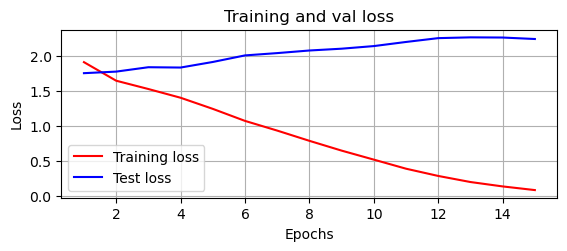

/var/folders/rx/s18ghmds1d13qrm0mss9rjzh0000gn/T/ipykernel_36256/2025745693.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


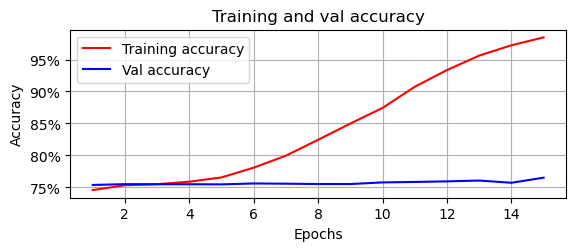

In [25]:
#__main()__
history = train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val, N_train_samples, N_val_samples)
plot_training_history(history)

## Built the inference model

In [26]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

# Solve the problem that colab cannot show Chinese plotting
import matplotlib.font_manager as fm
path = '//content/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# plot_attention_weights function from https://github.com/thushv89/attention_keras/blob/master/src/examples/utils/model_helper.py
def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))
        
def built_inference_model(batch_size = 1, latent_dim = 300):
    # Encoder (Inference) model
    encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
    enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
    # Encode the input sequence to get the "Context vectors"
    encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])
    #encoder_model.summary()

    # Decoder (Inference) model
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
    encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
    decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
    # Get the embeddings of the decoder sequence
    dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
    # Final decoder model
    decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],\
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    #decoder_model.summary()

    return encoder_model, decoder_model

# decode token with k beam search
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

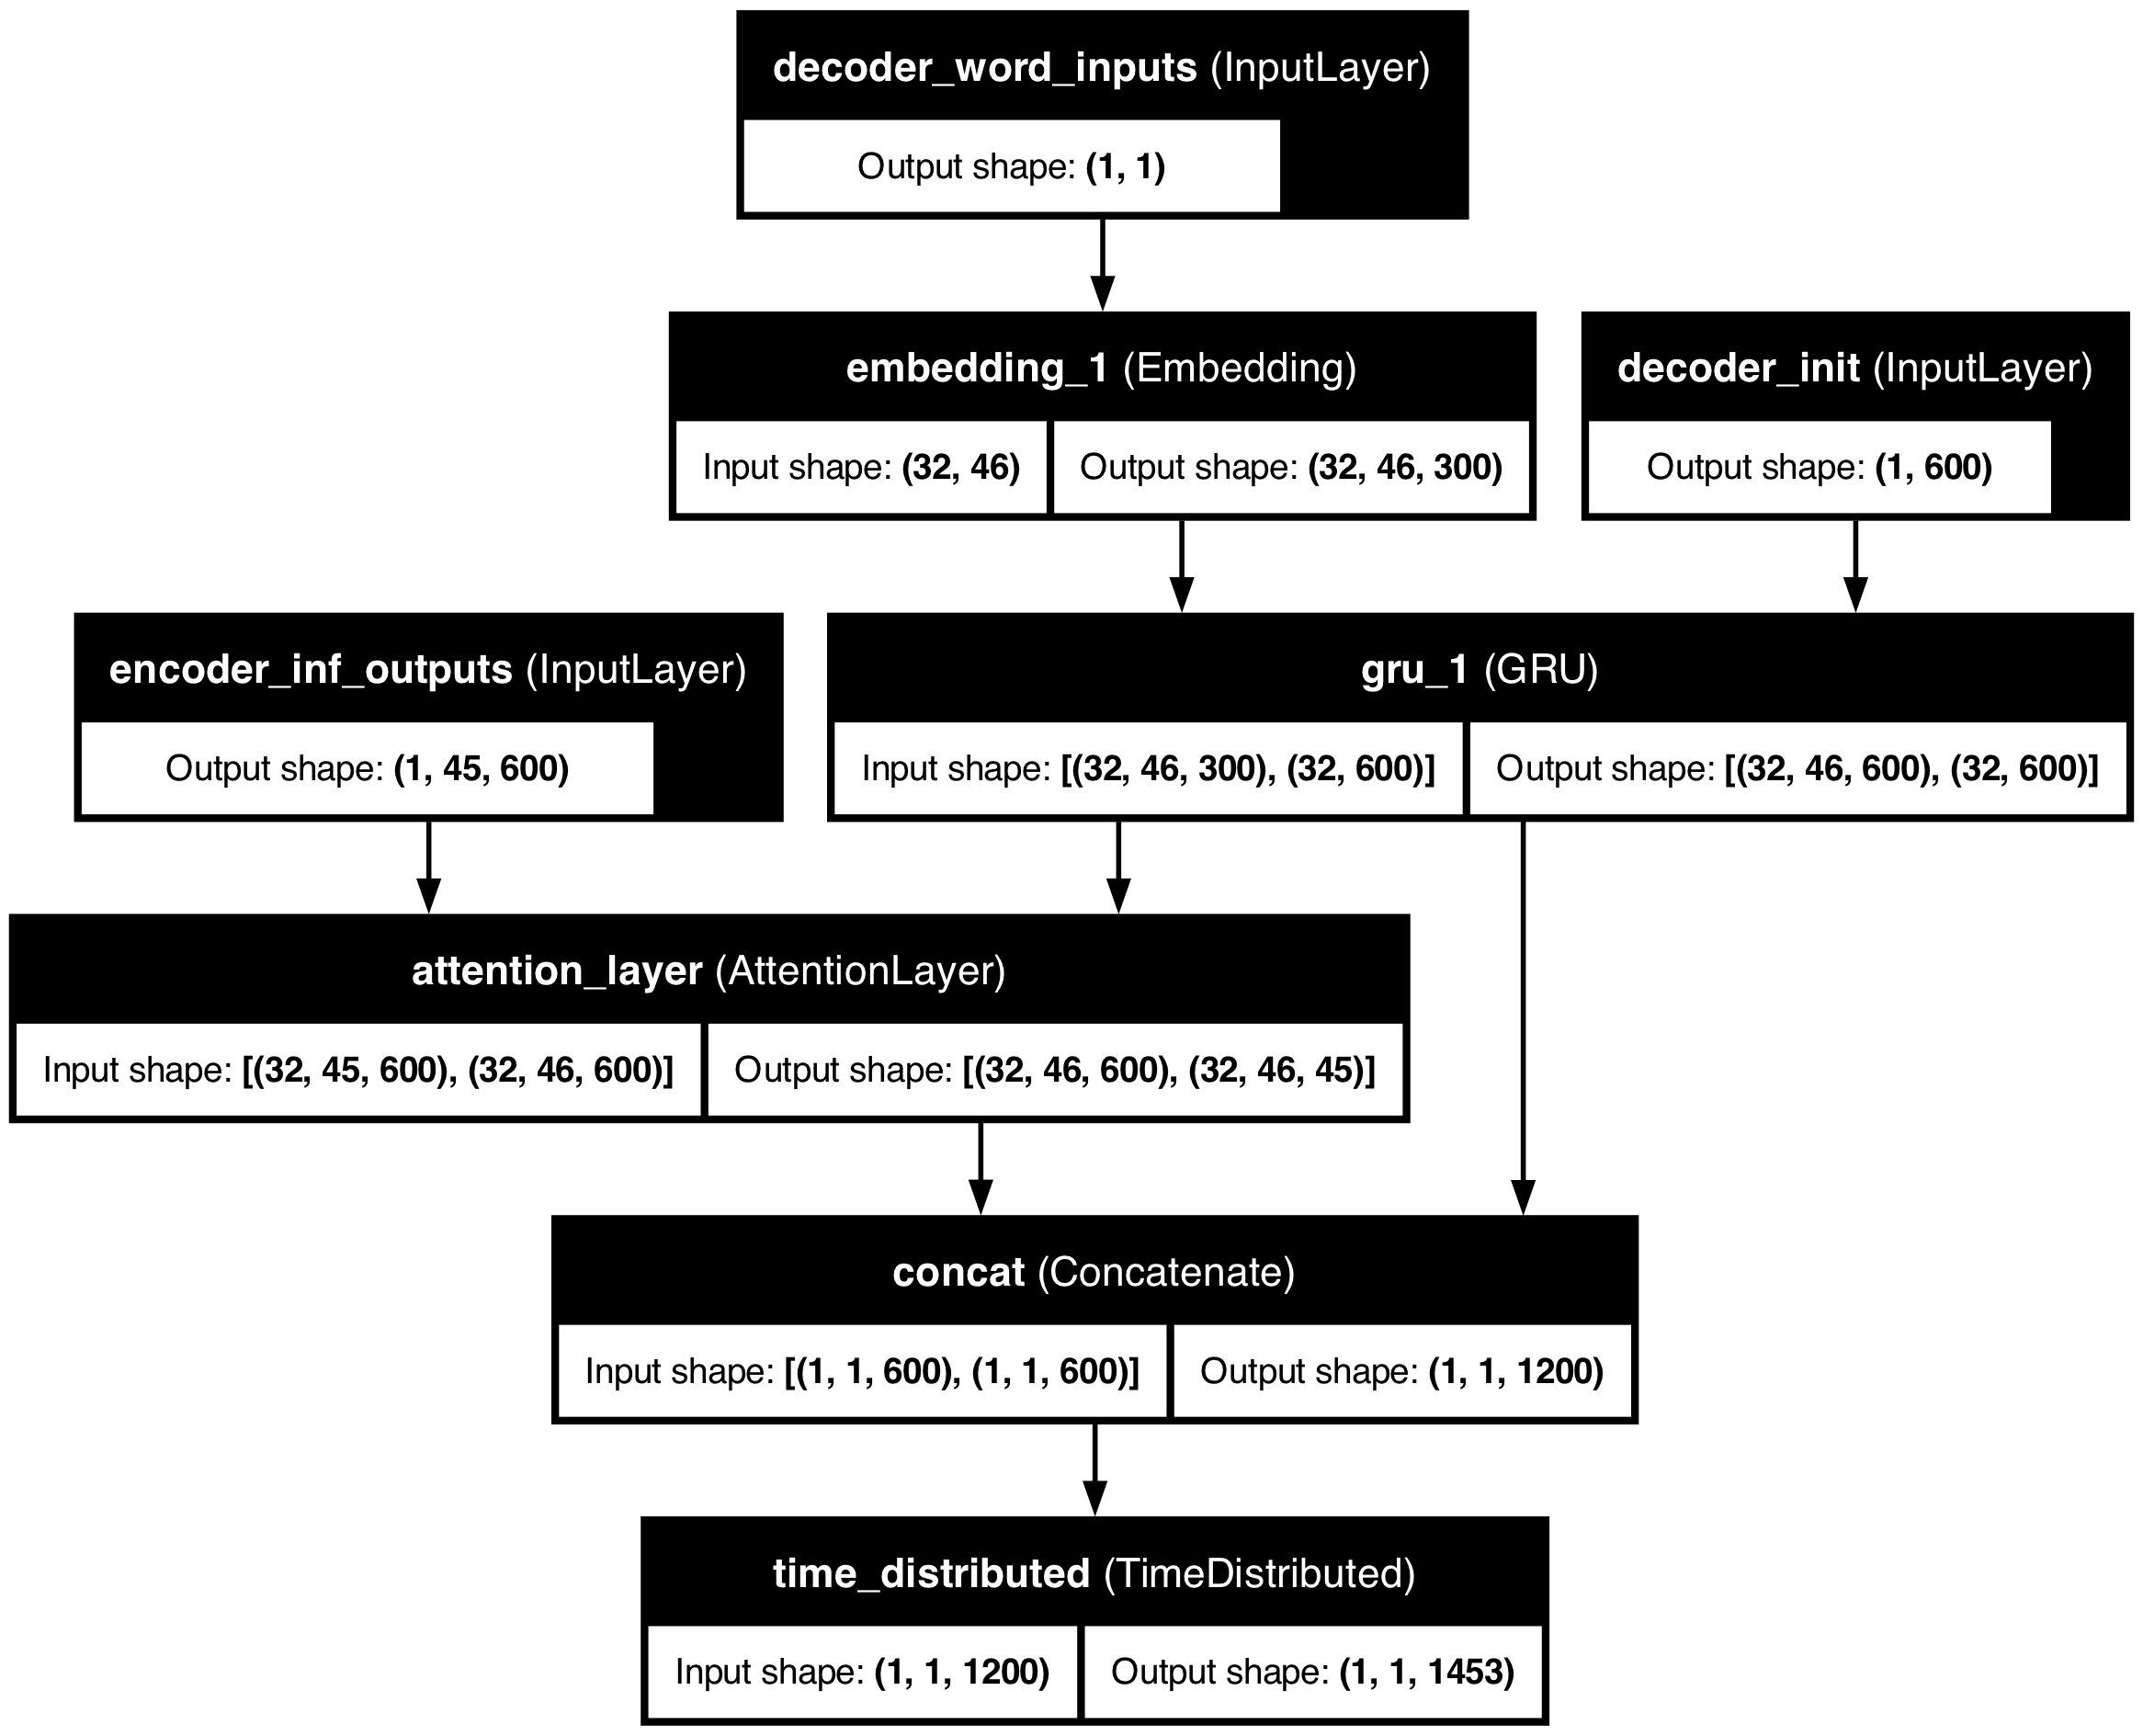

In [27]:
#__main()__
encoder_model, decoder_model = built_inference_model(batch_size = 1, latent_dim = 300)
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

## Test deom

In [28]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

In [29]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual   Target  Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# # Attention plotting
# plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

Batch (sample): [  9  98 202  88   5  16 201 192 179  93  93 209 191 153   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [31]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from sacrebleu.metrics import CHRF  # Importing chrF from sacrebleu

# Initialize the chrF metric once to use in the function
chrf_metric = CHRF()

# Function to calculate all evaluation metrics for machine translation, including chrF
def calculate_translation_metrics(reference, hypothesis):
    smoothie = SmoothingFunction().method1
    scores = {
        'BLEU-1': sentence_bleu([reference], hypothesis, weights=(1, 0, 0, 0), smoothing_function=smoothie),
        'BLEU-2': sentence_bleu([reference], hypothesis, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie),
        'BLEU-3': sentence_bleu([reference], hypothesis, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie),
        'METEOR': meteor_score([reference], hypothesis),
        'ROUGE': Rouge().get_scores(' '.join(hypothesis), ' '.join(reference))[0],
        'chrF': chrf_metric.sentence_score(' '.join(hypothesis), [' '.join(reference)]).score  # Adding chrF score
    }
    return scores


In [32]:
# Main loop for translation metrics calculation
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size=1)
N_samples = N_train_samples

# Store all scores in dictionaries, including chrF
metrics = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'METEOR': [], 'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': [], 'chrF': []}

for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    
    # Extract reference and predicted translations
    reference = [sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]
    test = [sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    
    # Calculate all metrics, including chrF
    scores = calculate_translation_metrics(reference[0], test[0])
    
    # Store individual scores
    metrics['BLEU-1'].append(scores['BLEU-1'])
    metrics['BLEU-2'].append(scores['BLEU-2'])
    metrics['BLEU-3'].append(scores['BLEU-3'])
    metrics['METEOR'].append(scores['METEOR'])
    metrics['ROUGE-1'].append(scores['ROUGE']['rouge-1']['f'])
    metrics['ROUGE-2'].append(scores['ROUGE']['rouge-2']['f'])
    metrics['ROUGE-L'].append(scores['ROUGE']['rouge-l']['f'])
    metrics['chrF'].append(scores['chrF'])  # Store chrF score
    
    # Print the details for each sample
    print(f'Sample: {i + 1} out of {N_samples}\n')
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Scores:', {metric: scores[metric] for metric in scores if metric != 'ROUGE'})
    print('ROUGE scores:', {k: v for k, v in scores['ROUGE'].items()})
    print('chrF score:', scores['chrF'])
    print("-------------------------------------------------------------------------------------------------------------------------")

# Calculate and print the average scores for all metrics, including chrF
print("Average Scores:")
for metric in metrics:
    if 'ROUGE' not in metric and metric != 'chrF':
        print(f"Average {metric} score: {sum(metrics[metric]) / N_samples if N_samples > 0 else 0}")
    elif metric == 'chrF':
        print(f"Average chrF score: {sum(metrics['chrF']) / N_samples if N_samples > 0 else 0}")
    else:
        # Compute average of ROUGE scores for 'f' measure
        print(f"Average {metric} score: {sum(d for d in metrics[metric]) / N_samples if N_samples > 0 else 0}")


Batch (sample): [  9  98 202  88   5  16 201 192 179  93  93 209 191 153   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 4 out of 478

Input Source s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 7 out of 478

Input Source sentence: 𛋟 𛅸 𛈷 𛆝 𛊝 𛆕 𛋟 𛋴 𛆳 𛇄 𛊝 𛇇
Actua

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 10 out of 478

Input Source sentence: 𛈥 𛇤 𛋳 𛋌 𛆑 𛉼 𛇂 𛆬 𛋪 𛅳
Actual Target Translation: 热 来 寻 扇 子 冷 去 对 美 人
Predicted Target Translation: 热 来 寻 扇 子 冷 去 对 美 人
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9995, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 6  5  4 34 36 59 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 15 out of 478

Input Source sentence: 𛉬 𛇈 𛆸 𛆓 𛆷 𛆳 𛇁 𛋶 𛇰
Actual Target Translation: 学 ⽽ 时 习 之 不 亦 说 乎
Predicted Target Translation: 学 ⽽ 时 习 之 不 亦 说 乎
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9993141289437586, 'chrF': 100.0}
ROU

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 21 out of 478

Input Source sentence: 𛈻 𛇁 𛆱 𛆷 𛋪 𛅾 𛋸
Actual Target Translation: 我 欲 因 之 梦 寥 廓
Predicted Target Translation: 我 欲 因 之 梦 寥 廓
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.9999999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 25 out of 478

Input Source sentence: 𛆞 𛊝 𛆼 𛈌 𛊌 𛅸 𛆈 𛊚 𛇋
Actual Target Translation: 恰 似 一 江 春 水 向 东 流
Predicted Target Translation: 恰 似 一 江 春 水 向 东 流
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9993141289437586, 'chrF': 100.0}
R

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 28 out of 478

Input Source sentence: 𛆼 𛆸 𛊐 𛆦 𛋛 𛆼 𛆸 𛊐 𛈨 𛉊
Actual Target Translation: 一 时 结 扁 豆 一 时 结 西 瓜
Predicted Target Translation: 一 时 结 扁 豆 一 时 结 西 瓜
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9995, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
---------------------------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 32 out of 478

Input Source sentence: 𛅳 𛇏 𛇄 𛋪 𛆼 𛊵 𛇐 𛇟 𛈌 𛇃
Actual Target Translation: 人 生 如 梦 一 尊 还 酹 江 月
Predicted Target Translation: 人 生 如 梦 一 尊 还 酹 江 月
Scores: {'BLEU-1': 1.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 37 out of 478

Input Source sentence: 𛉉 𛉅 𛇛 𛆃 𛆀 𛇃 𛆥 𛅳 𛆚 𛅳
Actual Target Translation: 面 积 平 方 公 里 年 人 口 人
Predicted Target Translation: 面 面 平 平 平 平 方 公 里 年 人 口 人
Scores: {'BLEU-1': 0.6923076923076923, 'BLEU-2': 0.6354889093022426, 'BLEU-3': 0.6069900756683363, 'METEOR': 0.868991969315594, 'chrF': 67.98795516418436}
ROUGE scores: {'rouge-1': {'r': 0.8888888888888888, 'p': 1.0, 'f': 0.9411764656055364}, 'rouge-2': {'r': 0.7777777777777778, 'p': 0.7, 'f': 0.7368421002770082}, 'rouge-l': {'r': 0.8888888888888888, 'p': 1.0, 'f': 0.9411764656055364}}
chrF score: 67.98795516418436
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [111  32  53 123 124 131 169  36  55  28   5  98 210  77   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample: 40 out of 478

Input Source sentence: 𛊺 𛉑 𛊼 𛆁 𛊵 𛆑 𛇉 𛆝
Actual Target Translation: 窈 窕 淑 女 君 子 好 逑
Predicted Target Translation: 窈 窕 淑 女 君 子 好 逑
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9990234375, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [118  53 193  17   8  16   4  29   3  16   3   3   3 227  81  30   6  39
  16   4  29   3   7  18 121  81  53  17  36   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 42 out of 478

Input Source sentence: 𛅳 𛇏 𛈤 𛇰 𛉅 𛇯 𛊅 𛇋 𛉛 𛈁 𛇹 𛉓 𛊧 𛊭
Actual Target Translation: 人 生 自 古 谁 无 死 留 取 丹 心 照 汗 青
Predicted Target Translation: 人 生 自 古 谁 无 死 留 取 丹 心 照 汗 青
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [  3  28   2  75  13  28 239   6   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 49 out of 478

Input Source sentence: 𛋙 𛆁 𛊉 𛇯 𛈌 𛉰 𛋭 𛆓 𛆄 𛋙
Actual Target Translation: 神 女 应 无 恙 当 惊 世 界 殊
Predicted Target Translation: 神 女 神 杨 下 下 闰 下 下 下 下
Scores: {'BLEU-1': 0.18181818181818182, 'BLEU-2': 0.13483997249264845, 'BLEU-3': 0.06036431606009924, 'METEOR': 0.09900990099009903,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 52 out of 478

Input Source sentence: 𛈂 𛊢 𛋳 𛆷 𛆨 𛇥 𛅸 𛈌 𛈍
Actual Target Translation: 溯 游 从 之 宛 在 水 中 央
Predicted Target Translation: 溯 从 从 之 宛 在 水 中 沚
Scores: {'BLEU-1': 0.7777777777777778, 'BLEU-2': 0.6972166887783963, 'BLEU-3': 0.6552698332604686, 'METEOR': 0.7687074829931974, 'chrF': 52.070105820105816}
ROUGE scores: {'rouge-1': {'r': 0.7777777777777778, 'p': 0.875, 'f': 0.823529406782007}, 'rouge-2': {'r': 0.625, 'p': 0.625, 'f': 0.624999995}, 'rouge-l': {'r': 0.7777777777777778, 'p': 0.875, 'f': 0.823529406782007}}
chrF score: 52.070105820105816
--------------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 55 out of 478

Input Source s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 58 out of 478

Input Source sentence: 𛈌 𛇌 𛆾 𛉄 𛆸 𛇏 𛆱 𛉄 𛇯 𛈤 𛆖 𛈖 𛊛 𛆂 𛆸 𛇐
Actual Target Translation: 其 中 北 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 63 out of 478

Input Source sentence: 𛈒 𛆻 𛆒 𛆭 𛈁 𛊙 𛇐 𛊰 𛉘 𛉶
Actual Target Translation: 晨 起 动 征 铎 客 行 悲 故 乡
Predicted Target Translation: 晨 腾 急 金 金 金 金 为 高 高
Scores: {'BLEU-1': 0.10000000000000002, 'BLEU-2': 0.03333333333333335, 'BLEU-3': 0.024950558772614845, 'METEOR': 0.05000000000000001, 'chrF': 1.6666666666666667}
ROUGE scores: {'rouge-1': {'r': 0.1, 'p': 0.16666666666666666, 'f': 0.12499999531250018}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.1, 'p': 0.16666666666666666, 'f': 0.12499999531250018}}
chrF score: 1.6666666666666667
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 13 188 152  81  17 249 127 188 152 16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 65 out of 478

Input Source sentence: 𛈷 𛆳 𛆱 𛈌 𛉺
Actual Target Translation: 能 不 忆 江 南
Predicted Target Translation: 能 能 忆 江 南 南
Scores: {'BLEU-1': 0.6666666666666666, 'BLEU-2': 0.5163977794943222, 'BLEU-3': 0.4091569047284194, 'METEOR': 0.618872549019608, 'chrF': 31.167471819645726}
ROUGE scores: {'rouge-1': {'r': 0.8, 'p': 1.0, 'f': 0.8888888839506174}, 'rouge-2': {'r': 0.5, 'p': 0.4, 'f': 0.4444444395061729}, 'rouge-l': {'r': 0.8, 'p': 1.0, 'f': 0.8888888839506174}}
chrF score: 31.167471819645726
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [  2  21  52 219 257  17  56  19  66  48   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 69 out of 478

Input Source sentence: 𛆑 𛇥 𛊯 𛆈 𛆴 𛆓 𛈖 𛇄 𛊸 𛆔
Actual Target Translation: 子 在 川 上 曰 逝 者 如 斯 夫
Predicted Target Translation: 子 在 川 上 曰 逝 者 如 斯 夫
Scores: {'BLEU-1': 1.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 73 out of 478

Input Source 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 76 out of 478

Input Source sentence: 𛆊 𛇣 𛆊 𛆉 𛆒 𛅹 𛆑 𛈛 𛈛 𛅹 𛇣 𛇈 𛊸 𛊤
Actual Target Translation: 三 拜 三 千 徒 弟 子 深 深 礼 拜 入 师 堂
Predicted Target Tra

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 79 out of 478

Input Source sentence: 𛇽 𛉓 𛈩 𛅹 𛊝 𛇥 𛆉 𛉄
Actual Target Translation: 老 骥 伏 枥 志 在 千 里
Predicted Target Translation: 精 诚 伏 枥 枥 志 在 千 里
Scores: {'BLEU-1': 0.6666666666666666, 'BLEU-2': 0.6454972243679028, 'BLEU-3': 0.566367013455331, 'METEOR': 0.7270233196159123, 'chrF': 42.21985784485784}
ROUGE scores: {'rouge-1': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}, 'rouge-2': {'r': 0.7142857142857143, 'p': 0.625, 'f': 0.6666666616888889}, 'rouge-l': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}}
chrF score: 42.21985784485784
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 33  66 104  55  75  15 126   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 83 out of 478

Input Source sentence: 𛅸 𛆳 𛇥 𛈛 𛈶 𛉴 𛈤 𛉀
Actual Target Translation: 水 不 在 深 有 龙 则 灵
Predicted Target Translation: 水 不 在 金 千 龙 则 灵
Scores: {'BLEU-1': 0.75, 'BLEU-2': 0.6546536707079771, 'BLEU-3': 0.5261597794341889, 'METEOR': 0.7361111111111112, 'chrF': 27.579365079365076}
ROUGE scores: {'rouge-1': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}, 'rouge-2': {'r': 0.5714285714285714, 'p': 0.5714285714285714, 'f': 0.5714285664285715}, 'rouge-l': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}}
chrF score: 27.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 86 out of 478

Input Source sentence: 𛆉 𛇞 𛆼 𛈤 𛉅 𛆱 𛊝
Actual Target Translation: 纤 笔 一 枝 谁 与 似
Predicted Target Translation: 千 里 一 一 直 有 空
Scores: {'BLEU-1': 0.14285714285714285, 'BLEU-2': 0.048795003647426664, 'BLEU-3': 0.037468614372419724, 'METEOR': 0.07142857142857142, 'chrF': 2.380952380952381}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}, 'rouge-2': {'r': 0.0, 'p': 0.0, '

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 89 out of 478

Input Source sentence: 𛇍 𛊸 𛇁 𛊩 𛇹 𛆳 𛉽 𛅵 𛅱 𛆸 𛋙 𛉌 𛇥 𛇹
Actual Target Translation: 左 思 右 想 心 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 93 out of 478

Input Source sentence: 𛇧 𛆺 𛇷 𛇁 𛆼 𛆊 𛆥 𛆼 𛉄 𛉄 𛉅 𛉄 𛉾 𛅻 𛋆

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 98 out of 478

Input Source sentence: 𛅳 𛈖 𛋧 𛇏 𛇟 𛈖 𛆒
Actual Target Translation: 仁 者 乐 山 知 者 动
Predicted Target Translation: 仁 者 乐 知 者 寿 者 寿
Scores: {'BLEU-1': 0.625, 'BLEU-2': 0.5175491695067657, 'BLEU-3': 0.35844139094416977, 'METEOR': 0.35211267605633806, 'chrF': 22.844850875297173}
ROUGE scores: {'rouge-1': {'r': 0.6666666666666666, 'p': 0.8, 'f': 0.7272727223140496}, 'rouge-2': {'r': 0.5, 'p': 0.5, 'f': 0.4999999950000001}, 'rouge-l': {'r': 0.6666666666666666, 'p': 0.8, 'f': 0.7272727223140496}}
chrF score: 22.844850875297173
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 48  77  40   2  74 117  58   7   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 102 out of 478

Input Source sentence: 𛉢 𛊂 𛈽 𛆌 𛇕 𛆳 𛋥 𛊢 𛉴 𛋳 𛆼 𛅸 𛈒 𛆂
Actual Target Translation: 鸿 雁 长 飞 光 不 度 鱼 龙 潜 跃 水 成 文
Predicted Target Translation: 鸿 雁 越 飞 光 度 飞 飞 飞 红 雁
Scores: {'BLEU-1': 0.3460456303167608, 'BLEU-2': 0.2295407032205458, 'BLEU-3': 0.07816213905649122, 'METEOR': 0.18248175182481755, 'chrF': 8.907192797624747}
ROUGE scores: {'rouge-1': {'r': 0.35714285714285715, 'p': 0.71428571

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 106 out of 478

Input Source sentence: 𛋙 𛋔 𛈽 𛅿 𛇼 𛈡 𛆌
Actual Target Translation: 昆 鸡 长 笑 老 鹰 非
Predicted Target Translation: 洞 化 长 神 秀 阴 阴 割
Scores: {'BLEU-1': 0.12500000000000003, 'BLEU-2': 0.04225771273642583, 'BLEU-3': 0.032085442892067474, 'METEOR': 0.07042253521126761, 'chrF': 2.3148148148148144}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.14285714285714285, 'f': 0.14285713785714302}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.14285714285714285, 'f': 0.14285713785714302}}
chrF score: 2.3148148148148144
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 91 247  72 181  91   3 247   9 308   2 248   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 110 out of 478

Input Source sentence: 𛉒 𛆸 𛇾 𛇃 𛊧 𛆸 𛇕 𛈄 𛉄 𛈽 𛆭 𛅳 𛆨 𛇐
Actual Target Translation: 秦 时 明 月 汉 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 113 out of 478

Input Source sentence: 𛇎 𛋳 𛊨 𛆽 𛊭 𛋂 𛆑
Actual Target Translation: 赤 橙 黄 绿 青 蓝 紫
Predicted Target Translation: 赤 橙 开 向 陇 东 风
Scores: {'BLEU-1': 0.2857142857142857, 'BLEU-2': 0.2182178902359924, 'BLEU-3': 0.1006949130683619, 'METEOR': 0.26785714285714285, 'chrF': 7.5396825396825395}
ROUGE scores: {'rouge-1': {'r': 0.2857142857142857, 'p': 0.2857142857142857, 'f': 0.2857142807142858}, 'rouge-2': {'r': 0.16666666666666666, 'p': 0.16666666666666666, 'f': 0.16666666166666683}, 'rouge-l': {'r': 0.2857142857142857, 'p': 0.2857142857142857, 'f': 0.2857142807142858}}
chrF sc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 119 out of 478

Input Source sentence: 𛆇 𛈀 𛊭 𛇏 𛉵 𛆬 𛈚 𛋰 𛊘 𛆼 𛇙 𛇈 𛇙 𛇤
Actual Target Translation: 两 岸 青 山 相 对 出 孤 帆 一 片 日 边 来
Predicted Target Translation: 两 岸 猿 生 曾 云 决 入 归 亮
Scor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 122 out of 478

Input Source sentence: 𛋭 𛇉 𛉊 𛆝 𛆼 𛅸 𛆃 𛈌 𛇏 𛆑 𛈅 𛉅 𛈯 𛇏
Actual Target Translation: 京 口 瓜 洲 一 水 间 钟 山 只 隔 数 重 山
Predicted Target Translation: 别 家 别 时 水 和 江 开 留 散 水 上
Scores: {'BLEU-1': 0.07054014374088449, 'BLEU-2': 0.023298642673655674, 'BLEU-3': 0.017291321630724565, 'METEOR': 0.036231884057971016, 'chrF': 1.2254901960784315}
ROUGE scores: {'rouge-1': {'r': 0.07692307692307693, 'p': 0.1, 'f': 0.08695651682419688}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.07692307692307693, 'p': 0.1, 'f': 0.08695651682419688}}
chrF score: 1.2254901960784315
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [151 152 164 127  40 150 308 166 166 327 240  55 262  24   0   0   0   0
   0   0   0   0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 125 out of 478

Input Source sentence: 𛈽 𛋆 𛉖 𛋈 𛋶 𛈶 𛆸 𛋔 𛉌 𛉍 𛊘 𛉒 𛉱 𛉝
Actual Target Translation: 长 风 破 浪 会 有 时 直 挂 云 帆 济 沧 海
Predicted Target Translation: 长 风 破 浪 会 有 时 直 挂 云 帆 济 沧 海
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 129 out of 478

Input Source sentence: 𛋵 𛉫 𛇓 𛈨 𛋗 𛊝 𛊲
Actual Target Translation: 眼 角 眉 梢 都 似 恨
Predicted Target Translation: 眼 角 眉 梢 都 似 恨
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 139 out of 478

Input Source sentence: 𛈂 𛇳 𛋳 𛆷 𛋛 𛊽 𛊴 𛈽
Actual Target Translation: 溯 洄 从 之 道 阻 且 长
Predicted Target Translation: 所 谓 伊 人 之 水 之 涘
Scores: {'BLEU-1': 0.12500000000000003, 'BLEU-2': 0.04225771273642583, 'BLEU-3': 0.032085442892067474, 'METEOR': 0.0625, 'chrF': 2.083333333333333}
ROUGE scores: {'rouge-1': {'r': 0.125, 'p': 0.14285714285714285, 'f': 0.13333332835555575}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.125, 'p': 0.14285714285714285, 'f': 0.13333332835555575}}
chrF score: 2.083333333333333
-------------------------------------------------------------------------------------------------------------------------
Bat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 142 out of 478

Input Source sentence: 𛇩 𛆻 𛈈 𛇾 𛇃 𛅾 𛇊 𛊸 𛉘 𛉶
Actual Target Translation: 夜 起 望 明 月 低 头 思 故 乡
Predicted Target Translation: 荡 头 望 明 月 低 头 思 故 乡
Scores: {'BLEU-1': 0.8, 'BLEU-2': 0.7888106377466155, 'BLEU-3': 0.7776286229411347, 'METEOR': 0.7992187500000002, 'chrF': 71.8121693121693}
ROUGE scores: {'rouge-1': {'r': 0.8, 'p': 0.8888888888888888, 'f': 0.8421052581717452}, 'rouge-2': {'r': 0.7777777777777778, 'p': 0.777777777

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 145 out of 478

Input Source sentence: 𛇅 𛆹 𛈌 𛋬 𛈾 𛇖 𛆖 𛋻 𛅳 𛉘 𛅳 𛆵 𛆖 𛈤 𛆅 𛇵 𛅿 𛅵
Actual Target Translation: 本 社 区 共 有 户 总 人 口 人 划 分 为 个 居 民 小 组
Predicted Target Translation: 应 当 注 已 已 已 已 最 将 将 将 公 方
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rou

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sample: 148 out of 478

Input Source sentence: 𛈻 𛉊 𛅿 𛈏 𛋣 𛇊 𛋙 𛉸 𛉸 𛈣 𛇶 𛋠 𛋉 𛇐
Actual Target Translation: 我 家 洗 砚 池 头 树 朵 朵 花 开 淡 墨 痕
Predicted Target Translation: 我 家 洗 砚 夜 头 去 风 风 风 风 风 风
Scores: {'BLEU-1': 0.3561388764008908, 'BLEU-2': 0.2871283415733421, 'BLEU-3': 0.24358584231999433, 'METEOR': 0.34820143884892085, 'chrF': 14.313073459059348}
ROUGE scores: {'rouge-1':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 151 out of 478

Input Source sentence: 𛇌 𛆚 𛈄 𛅸 𛆇 𛋳 𛅸 𛆇 𛆼 𛋳 𛈄 𛆚 𛆌 𛋳 𛅸 𛆇 𛆱 𛋳 𛈄 𛆚 𛆌 𛆠 𛋳
Actual Target Translation: 车 站 为 地 下 两 层 地 下 一 层 为 站 厅 层 地 下 二 层 为 站 台 层
Predicted Target Translation: 车 站 为 为 飞 车 层 为 站 台 层
Scores: {'BLEU-1': 0.2748362573774965, 'BLEU-2': 0.2353557098042542, 'BLEU-3': 0.20325176481693455, 'METEOR': 0.3774493147581833, 'chrF': 18.87500950489875}
ROUGE scores: {'rouge-1': {'r': 0.45454545454545453, 'p': 0.8333333333333334, 'f': 0.5882352895501731}, 'rouge-2': {'r': 0.35294117647058826, 'p': 0.6, 'f': 0.4444444397805213}, 'rouge-l': {'r': 0.45454545454545453, 'p': 0.8333333333333334, 'f': 0.5882352895501731}}
chrF score: 18.87500950489875
--------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 153 out of 478

Input Source sentence: 𛇧 𛇃 𛈌 𛇥 𛉄 𛇹 𛆚 𛅸 𛆚 𛆱 𛇲 𛇱 𛇩 𛊤 𛉺 𛈅 𛇈 𛊚 𛈅 𛇌 𛈅
Actual Target Translation: 该 地 区 英 语 的 口 音 有 别 于 美 国 南 部 和 东 北 部 城 市
Predicted Target Translation: 该 江 东 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 国 国 国 月 月 <end>
Scores: {'BLEU-1': 0.12121212121212123, 'BLEU-2': 0.01946247360403808, 'BLEU-3': 0.011187198528757042, 'METEOR': 0.09009009009009009, 'chrF': 2.7548209366391183}
ROUGE scores: {'rouge-1': {'r': 0.2, 'p': 0.5714285714285714, 'f': 0.29629629245541844}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rou

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 156 out of 478

Input Source sentence: 𛈉 𛋋 𛇾 𛇃 𛇕 𛊺 𛆹 𛊤 𛆈 𛈊
Actual Target Translation: 床 前 明 月 光 疑 是 地 上 霜
Predicted Target Translation: 装 月 明 月 光 疑 是 白 照 不
Scores: {'BLEU-1': 0.5, 'BLEU-2': 0.4714045207910317, 'BLEU-3': 0.44042320075255215, 'METEOR': 0.498, 'chrF': 29.530423280423285}
ROUGE scores: {'rouge-1': {'r': 0.5, 'p': 0.5555555555555556, 'f': 0.5263157844875347}, 'rouge-2': {'r': 0.4444444444444444, 'p': 0.4444444444444444, 'f': 0.44444443944444445}, 'rouge-l': {'r': 0.5, 'p': 0.5555555555555556, 'f': 0.5263157844875347}}
chrF score: 29.530423280423285
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 76 106 189  26  80  26 189  26  80  26 117  93  85  80 114  93 117 116
 271  80 114   0   0   0   0   0   0   0   0   0   0   0   0   0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sample: 160 out of 478

Input Source sentence: 𛆳 𛊝 𛊌 𛇕 𛋐 𛊝 𛊌 𛇕
Actual Target Translation: 不 似 春 光 胜 似 春 光
Predicted Target Translation: 不 似 似 光 胜 似 似 光 光 光
Scores: {'BLEU-1': 0.6, 'BLE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 163 out of 478

Input Source sentence: 𛉻 𛊼 𛇍 𛆹 𛇤 𛉚 𛆸 𛇾 𛆹 𛇹 𛆬 𛇩 𛆹 𛇤 𛆳 𛆷 𛇃 𛇲
Actual Target Translation: 但

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 164 out of 478

Input Source sentence: 𛉼 𛇄 𛅸 𛆀 𛇘 𛇼 𛆆 𛈺 𛆀 𛇼 𛅸 𛆀 𛉽 𛉼 𛅸 𛆀
Actual Target Translation: 另 外 水 塔 还 分 成 一 般 水 塔 跟 冷 却 水 塔
Predicted Target Translation: 另 外 水 塔 为 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外 外
Scores: {'BLEU-1': 0.08695652173913045, 'BLEU-2': 0.07613869876268808, 'BLEU-3': 0.06589616076662635, 'METEOR'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 167 out of 478

Input Source sentence: 𛉎 𛊃 𛅳 𛇵 𛆼 𛆸 𛊛
Actual Target Translation: 保 安 人 物 一 时 新
Predicted Target Translation: 无 和 独 人 物 一 人 物
Scores: {'BLEU-1': 0.375, 'BLEU-2': 0.32732683535398854, 'BLEU-3': 0.2649097550589377, 'METEOR': 0.3599374021909233, 'chrF': 15.526844331192155}
ROUGE scores: {'rouge-1': {'r': 0.42857142857142855, 'p': 0.5, 'f': 0.4615384565680473}, 'rouge-2': {'r': 0.3333333333333333, 'p': 0.3333333333333333, 'f': 0.3333333283333334}, 'rouge-l': {'r': 0.42857142857142855, 'p': 0.5, 'f': 0.4615384565680473}}
chrF score: 15.526844331192155
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [  4  84   2 203  24 106 182  18  68   0   0   0   0   0   0   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 170 out of 478

Input Source sentence: 𛆼 𛉊 𛈤 𛉓 𛇥 𛆱 𛇮 𛆼 𛇏 𛈤 𛉓 𛇥 𛆱 𛊝
Actual Target Translation: 一 家 之 计 在 与 和 一 生 之 计 在 于 勤
Predicted Target Translation: 一 曲 之 计 在 与 一 一 生 之 计 在 于 勤
Scores: {'BLEU-1': 0.8571428571428571, 'BLEU-2': 0.7703288865196432, 'BLEU-3': 0.7046262581472946, 'METEOR': 0.8504464285714286, 'chrF': 51.82585932585933}
ROUGE scores: {'rouge-1':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 174 out of 478

Input Source sentence: 𛅿 𛆧 𛉶 𛋳 𛋥 𛉆 𛇳
Actual Target Translation: 小 园 香 径 独 徘 回
Predicted Target Translation: 小 将 香 下 下 <end>
Scores: {'BLEU-1': 0.28216057496353797, 'BLEU-2': 0.06911494341909905, 'BLEU-3': 0.04795431301243788, 'METEOR': 0.14492753623188406, 'chrF': 4.385964912280701}
ROUGE scores: {'rouge-1': {'r': 0.2857142857142857, 'p': 0.4, 'f': 0.33333332847222225}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.2857142857142857, 'p'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 175 out of 478

Input Source sentence: 𛊤 𛇭 𛋅 𛆃 𛅳 𛈗 𛆅 𛊤 𛇎 𛈩 𛋬 𛆚 𛇶 𛇹
Actual Target Translation: 同 住 房 间 人 四 个 同 坐 合 唱 好 开 心
Predicted Target Translation: 该 广 州 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 82  53   2  64  56   4  11  63 177   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 179 out of 478

Input Source sentence: 𛇪 𛇷 𛊘 𛆽 𛅸 𛉢 𛇗 𛊭 𛆱 𛆑
Actual Target Translation: 白 毛 浮 绿 水 红 掌 青 叶 子
Predicted Target Translation: 荡 放 水 下 下 下 下 下
Scores: {'BLEU-1': 0.09735009788392564, 'BLEU-2': 0.03291033976993492, 'BLEU-3': 0.024988168049534992, 'METEOR': 0.05102040816326531, 'chrF': 1.7361111111111112}
ROUGE sco

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 183 out of 478

Input Source sentence: 𛉢 𛊵 𛆳 𛇲 𛋟 𛆭 𛈷
Actual Target Translation: 红 军 不 怕 远 征 难
Predicted Target Translation: 红 军 不 怕 远 征 难 难 不
Scores: {'BLEU-1': 0.7777777777777778, 'BLEU-2': 0.7637626158259734, 'BLEU-3': 0.7490836021568807, 'METEO

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 190 out of 478

Input Source sentence: 𛈿 𛈶 𛋫 𛇄 𛆷 𛊸
Actual Target Translation: 羊 有 跪 乳 之 恩
Predicted Target Translation: 羊 有 至 而 不 知 乎
Scores: {'BLEU-1': 0.2857142857142857, 'BLEU-2': 0.2182178902359924, 'BLEU-3': 0.1006949130683619, 'METEOR': 0.3073770491803279, 'chrF': 8.581752484191508}
ROUGE scores: {'rouge-1': {'r': 0.3333333333333333, 'p': 0.2857142857142857, 'f': 0.3076923027218935}, 'rouge

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 193 out of 478

Input Source sentence: 𛈱 𛇩 𛇐 𛋠 𛋪 𛋝 𛈣 𛆄 𛇇 𛊌 𛈺 𛆳 𛇐 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 199 out of 478

Input Source 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 203 out of 478

Input Source sentence: 𛆝 𛆃 𛆃 𛆹 𛆹 𛇩 𛆃 𛆃 𛆂 𛈌 𛇩 𛆹 𛆼 𛆱 𛆅 𛆷
Actual Target Translation: 交 通 工 程 是 运 输 工 程 学 中 的 一 个 分 支
Predicted Target Translation: 交 广 州 市 实 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 206 out of 478

Input Source sentence: 𛇐 𛋗 𛈷 𛇐 𛋗 𛈷 𛈁 𛆦 𛋗 𛆭 𛊃 𛇥
Actual Target Translation: 行 路 难 行 路 难 多 歧 路 今 安 在
Predicted Target Translation: 行 行 路 难 多 路 路 多 歧 路 多 安 <end> 多 <end> <end> <end> <end>
Scores: {'BLEU-1': 0.5, 'BLEU-2': 0.3834824944236852, 'BLEU-3': 0.3057471930187898, 'METEOR': 0.4634528708602783, 'chrF': 18.34568901216253}
ROUGE scores: {'rouge-1': {'r': 0.75, 'p': 0.8571428571428571, 'f': 0.7999999950222222}, 'rouge-2': {'r': 0.5555555555555556, 'p': 0.35714285714285715, 'f': 0.43478260393

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 210 out of 478

Input Source sentence: 𛋔 𛇀 𛇯 𛆒 𛈛 𛈇 𛈂 𛊭 𛉩
Actual Target Translation: 寂 寞 梧 桐 深 院 锁 清 秋
Predicted Target Translation: 寂 寞 梧 了 三 朵 高 高
Scores: {'BLEU-1': 0.3309363384692233, 'BLEU-2': 0.2888649183327127, 'BLEU-3': 0.23378203830395639, 'METEOR': 0.33083645443196, 'chrF': 12.406646532752724}
ROUGE scores: {'rouge

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 213 out of 478

Input Source sentence: 𛉜 𛈤 𛆞 𛈫 𛇃 𛆱 𛆥 𛆀 𛆸 𛆱 𛉄 𛇁 𛆸 𛆱 𛆱 𛆈 𛆸
Actual Target Translation: 北 美 首 映 日 期 年 月 日 台 湾 于 年 月 日 上 映
Predicted Target Translation: 交 配 路 月 月 年 年 月 日 日 台 湾 于
Scores: {'BLEU-1': 0.5089441019480893, 'BLEU-2': 0.3948343115813073, 'BLEU-3': 0.31768036181730097,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 216 out of 478

Input Source sentence: 𛊚 𛇇 𛋓 𛊍 𛆱 𛇕 𛉱 𛉝
Actual Target Translation: 东 临 碣 石 以 观 沧 海
Predicted Target Translation: 东 临 碣 石 有 遗 篇
Scores: {'BLEU-1': 0.4953587998572467, 'BLEU-2': 0.4633657281473354, 'BLEU-3': 0.42373591321983056, 'METEOR': 0.5023734177215189, 'chrF': 25.122578980251543}
ROUGE scores: {'rouge-1': {'r': 0.5, 'p': 0.5714285714285714, 'f': 0.5333333283555556}, 'rouge-2': 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 219 out of 478

Input Source sentence: 𛋆 𛇯 𛆳 𛆒 𛊃 𛇄 𛇏
Actual Target Translation: 风 雨 不 动 安 如 山
Predicted Target Translation: 风 雨 不 动 安 如 山
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [192 181 139 152  20 169  18   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 223 out of 478

Input Source sentence: 𛇪 𛇈 𛆱 𛇏 𛉑 𛊨 𛊕 𛇄 𛉝 𛇋
Actual Target Translation: 白 日 依 山 尽 黄 河 入 海 流
Predicted Target Translation: 空 积 跬 步 洋 下 下 欢
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 227 out of 478

Input Source sentence: 𛈱 𛆤 𛆂 𛅿 𛈖 𛆭 𛇈 𛇯 𛈼 𛊵
Actual Target Translation: 昨 天 文 小 姐 今 日 武 将 军
Predicted Target Translation: 天 天 开 事 天 下 下 下 下 下
Scores: {'BLEU-1':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 229 out of 478

Input Source sentence: 𛊮 𛇏 𛈌 𛆸 𛈌 𛅳 𛈌 𛆸 𛇹 𛇇 𛈶 𛆊 𛆄 𛋥 𛆐 𛈶 𛇠 𛇐 𛆊 𛆂 𛈤 𛊝 𛆊 𛆂 𛈤 𛉭 𛇁
Actual Target Translation: 青 森 市 中 央 市 民 中 心 前 有 一 块 刻 有 本 作 一 节 的 文 学 碑 友 情 之 碑
Predicted Target Translation: 青 下 一 时 了 最 了 在 在 最 高 中 将 将 公 在
Scores: {'BLEU-1': 0.09428092086955142, 'BLEU-2': 0.01777778092889923, 'BLEU-3': 0.010843777459050413, 'METEOR': 0.05791505791505791, 'chrF': 2.0161290322580645}
ROUGE scores: {'rouge-1': {'r': 0.13636363636363635, 'p': 0.2727272727272727, 'f': 0.18181817737373748}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.09090909090909091, 'p': 0.18181818181818182, 'f': 0.12121211676767694}}
chrF score: 2.0161290

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 233 out of 478

Input Source sentence: 𛉿 𛉊 𛉱 𛉱 𛇪 𛋗 𛆨 𛈊
Actual Target Translation: 蒹 葭 萋 萋 白 露 未 晞
Predicted Target Translation: 蒹 葭 采 采 白 露 未 已
Scores: {'BLEU-1': 0.625, 'BLEU-2': 0.5175491695067657, 'BLEU-3': 0.35844139094416977, 'METEOR': 0.605, 'chrF': 20.33730158730159}
ROUGE scores: {'rouge-1': {'r': 0.714285714285714

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 236 out of 478

Input Source sentence: 𛆆 𛋜 𛊨 𛉵 𛆑 𛆪 𛋮 𛅵 𛋜 𛊬 𛉴 𛉚 𛋨 𛈣
Actual Target Translation: 九 绣 韩 湘 子 吹 笛 十 绣 梅 良 玉 爱 花
Predicted Target Translation: 九 绣 凉 湘 吹 吹 笛 笛 十 绣 梅 鱼 鲤 双 双
Scores: {'BLEU-1': 0.5333333333333333, 'BLEU-2': 0.4364357804719848, 'BLEU-3': 0.3119507414338617, 'METEOR': 0.5319148936170213, 'chrF': 19.923235529856278}
ROUGE scores: {'rouge-1': {'r': 0.5384615384615384, 'p': 0.6363636363636364, 'f': 0.5833333283680556}, 'rouge-2': {'r': 0.38461538461538464, 'p': 0.35714285714285715, 'f': 0.3703703653772291}, 'rouge-l': {'r': 0.5384615384615384, 'p': 0.6363636363636364, 'f': 0.5833333283680556}}
chrF score: 19.923235529856278
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 22 134 226  36  55  86  19 111  32   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 240 out of 478

Input Source sentence: 𛉟 𛇈 𛈨 𛋥 𛆭 𛈷 𛉬 𛇊 𛋃 𛋵 𛈣 𛆳 𛊃 𛈔

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 243 out of 478

Input Source sentence: 𛋆 𛊵 𛇮 𛈷 𛇈 𛇹 𛋟 𛊤 𛈤 𛇙
Actual Target Translation: 问 君 何 能 尔 心 远 地 自 偏
Predicted Target Translation: 问 君 时 难 多 两 青 多 不 多
Scores: {'BLEU-1': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 247 out of 478

Input Source sentence: 𛇫 𛊢 𛋌 𛇰 𛊝 𛈌 𛆑 𛊻 𛋌 𛇜
Actual Target Translation: 伯 牙 善 鼓 琴 钟 子 期 善 听
Predicted Target Translation: 伯 牙 鼓 琴 志 在 最 之 何 也
Scores: {'BLEU-1': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 251 out of 478

Input Source sentence: 𛇏 𛇨 𛇀 𛉊 𛇙 𛆨 𛅽 𛊃
Actual Target Translation: 山 快 马 加 鞭 未 下 鞍
Predicted Target Translation: 山 倒 一 枝 无 与 似
Scores: {'BLEU-1': 0.12383969996431167, 'BLEU-2': 0.04229931028018368, 'BLEU-3': 0.03248071373371268, 'METEOR': 0.06329113924050632, 'chrF': 2.1367521367521367}
ROUGE scores: {'rouge-1': {'r': 0.125, 'p': 0.14285714285714285, 'f': 0.13333332835555575}, 'rou

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 257 out of 478

Input Source sentence: 𛆒 𛊭 𛉖 𛈍 𛉹 𛆤 𛊗
Actual Target Translation: 洞 庭 波 涌 连 天 雪
Predicted Target Translation: 洞 庭 波 涌 涌 连 衣
Scores: {'BLEU-1': 0.7142857142857143, 'BLEU-2': 0.6900655593423543, 'BLEU-3': 0.5785587016776487, 'METEOR': 0.6914285714285714, 'chrF': 33.84920634920635}
ROUGE scores: {'rouge-1': {'r': 0.7142857142857143, 'p': 0.8333333333333334, 'f': 0.7692307642603551}, 'r

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 261 out of 478

Input Source sentence: 𛋉 𛇈 𛆚 𛉬 𛆳 𛆸 𛅽 𛋆
Actual Target Translation: 敏 而 好 学 不 耻 下 问
Predicted Target Translation: 先 而 好 而 不 耻 者 寿
Scores: {'BLEU-1': 0.5, 'BLEU-2': 0.3779644730092272, 'BLEU-3': 0.13624724651304662, 'METEOR': 0.39453125, 'chrF': 13.095238095238097}
ROUGE scores: {'rouge-1': {'r': 0.5, 'p': 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 264 out of 478

Input Source sentence: 𛈂 𛆨 𛆱 𛅳 𛇥 𛅸 𛆼 𛆠
Actual Target Translation: 所 谓 伊 人 在 水 一 方
Predicted Target Translation: 所 谓 伊 人 在 水 之 涘
Scores: {'BLEU-1': 0.75, 'BLEU-2': 0.7319250547113999, 'BLEU-3': 0.7119309108013354, 'METEOR': 0.748263888888889, 'chrF': 59.404761904761905}
ROUGE scores: {'rouge-1': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}, 'rouge-2': {'r': 0.7142857142857143, 'p': 0.7142857142857143, 'f': 0.7142857092857143}, 'rouge-l': {'r': 0.75, 'p': 0.75, 'f': 0.749999995}}
chrF score: 59.404761904761905
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 82  18  20 132  74 107   3  46  44 217   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 268 out of 478

Input Source sentence: 𛆖 𛋫 𛆳 𛈷 𛆰 𛊘 𛋋 𛆳 𛈷 𛊺
Actual Target Translation: 富 贵 不 能 淫 贫 贱 不 能 移
Predicted Target Translation: 富 不 能 能 淫 贫 贱 不 能 移
Scores: {'BLEU-1': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 271 out of 478

Input Source sentence: 𛇰 𛇏 𛊢 𛆄 𛊝 𛅳 𛉬 𛆳 𛉲 𛋴
Actual Target Translation: 虎 生 犹 可 近 人 熟 不 堪 亲
Predicted Target Translation: 常 观 也 可 可 以 使 用 者 而
Scores: {'BLEU-1': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 274 out of 478

Input Source sentence: 𛆏 𛋡 𛈽 𛊾 𛅸 𛇁 𛊼 𛇯 𛈾 𛊢
Actual Target Translation: 才 饮 长 沙 水 又 食 武 昌 鱼
Predicted Target Translation: 才 饮 长 沙 水 又 食 武 昌 鱼
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9995, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 13  56  65   4   3  56 153   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 278 out of 478

Input Source sentence: 𛆇 𛅳 𛇭 𛇥 𛅿 𛆍 𛇏 𛈤 𛆇 𛆠 𛆐 𛋳 𛈤 𛇏 𛇃 𛆑 𛆫 𛅳 𛆚 𛆳 𛆸 𛇤 𛈤 𛊼
Actual Target Translation: 二 人 住 在 小 石 山 的 一 个 破 旧 的 窑 洞 内 孩 子 便 出 生 在 这 里
Predicted Target Translation: 二 广 州 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 解 迷 变 变 变 大 大 大 <end> 道 方 为 为
Scores: {'BLEU-1': 0.02702702702702703, 'BLEU-2': 0.008664587415167273, 'BLEU-3': 0.006300443932880217, 'METEOR': 0.019762845849802372, 'chrF': 0.6082725060827251}
ROUGE scores: {'rouge-1': {'r': 0.045454545454545456, 'p': 0.08333333333333333, 'f': 0.05882352484429102}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.045454545454545456, 'p': 0.08333333333333333, 'f': 0.05882352484429102}}
chrF score: 0.6082725060827251
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 94  47  79   2  49  19  30   8 177

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 282 out of 478

Input Source sentence: 𛉾 𛋐 𛇾 𛉅 𛇭 𛇾 𛆠 𛋶 𛊥 𛋀 𛈔 𛅿 𛈖 𛋛
Actual Target Translation: 姓 甚 名 谁 住 哪 方 范 郎 答 言 小 姐 道
Predicted Target Translation: 姓 冥 冥 期 小 姐 高 高 高 高 雨 雨 雨 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 283 out of 478

Input Source sentence: 𛊣 𛈅 𛈾 𛇭 𛈭 𛆹 𛊣 𛉘 𛈭 𛆱 𛇠 𛇁 𛇩 𛆒 𛇺 𛊣 𛈅 𛈅 𛈭
Actual Target Translation: 英 国 皇 家 徽 章 是 英 王 徽 因 此 也 成 为 英 国 国 徽
Predicted Target Translation: 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国 国
Scores: {'BLEU-1': 0.06521739130434781, 'BLEU-2': 0.03806934938134404, 'BLEU-3': 0.015518166841497432, 'METEOR': 0.11776753712237582, 'chrF': 2.7615591303460927}
ROUGE score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 286 out of 478

Input Source sentence: 𛇟 𛆌 𛆬 𛈱 𛊯 𛊘 𛇯
Actual Target Translation: 泪 飞 顿 作 倾 盆 雨
Predicted Target Translation: 泪 非 成 败 非 以 远 远
Scores: {'BLEU-1': 0.12500000000000003, 'BLEU-2': 0.04225771273642583, 'BLEU-3': 0.032085442892067474, 'METEOR': 0.07042253521126761, 'chrF': 2.3148148148148144}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}}
chrF score: 2.3148148148148144
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 56  89  65   9   3  56 140 110 221   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 290 out of 478

Input Source sentence: 𛇯 𛇌 𛋷 𛊝 𛈿 𛈘 𛇏 𛋮 𛋮 𛉱
Actual Target Translation: 雨 后 复 斜 阳 关 山 阵 阵 苍
Predicted Target Translation: 雨 雨 复 复 斜 春 春 风 红 春
Scores: {'BLEU-1': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 299 out of 478

Input Source sentence: 𛆥 𛆸 𛈶 𛅳 𛆚 𛊨 𛉄 𛅳 𛇍 𛇁
Actual Target Translation: 年 时 有 人 口 万 千 人 左 右
Predicted Target Translation: 年 广 州 市 实 行 市 长 制
Scores: {'BLEU-1': 0.09942659075715217, 'BLEU-2': 0.03334869235560668, 'BLEU-3': 0.02511556662162

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 302 out of 478

Input Source sentence: 𛇏 𛊯 𛆷 𛋪 𛇰 𛇤 𛈌 𛊤
Actual Target Translation: 山 川 之 美 古 来 共 谈
Predicted Target Translation: 山 川 之 之 审 者 无 昭 昭 之
Scores: {'BLEU-1': 0.3, 'BLEU-2': 0.25819888974716104, 'BLEU-3': 0.20600140803015504, 'METEOR': 0.3116531165311653, 'chrF': 13.062476607168206}
ROUGE scores: {'rouge-1': {'r': 0.375, 'p': 0.42857142857142855, 'f': 0.3999999950222222}, 'rouge-2': {'r': 0.2857142857142857, 'p': 0.2222222222222222, 'f': 0.24999999507812506}, 'rouge-l': {'r': 0.375, 'p': 0.42857142

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 306 out of 478

Input Source sentence: 𛇯 𛆙 𛆙 𛆷 𛅵 𛈖 𛇯 𛆙 𛆙 𛆷 𛇕
Actual Target Translation: 无 惛 惛 之 事 者 无 赫

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 309 out of 478

Input Source sentence: 𛅾 𛋸 𛈌 𛆤 𛈄 𛉄 𛈊
Actual Target Translation: 寥 廓 江 天 万 里 霜
Predicted Target Translation: 寥 廓 江 天 万 里 霜
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 311 out of 478

Input Source sentence: 𛇥 𛆶 𛈚 𛇏 𛆷 𛋆 𛅳 𛇖 𛈤 𛇼 𛆉 𛇏
Actual Target Translation: 在 他 出 生 之 前 父 亲 就 已 去 世
Predicted Target Translation: 在 他 就 出 出 在 生 待 生 生 生 为 双
Scores: {'BLEU-1': 0.38461538461538464, 'BLEU-2': 0.17902871850985821, 'BLEU-3': 0.06811917787742343, 'METEOR': 0.20661157024793386, 'chrF': 8.318706288948757}
ROUGE scores: {'rouge-1': {'r': 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 314 out of 478

Input Source sentence: 𛋓 𛋇 𛉍 𛇏 𛉍 𛇯 𛋂 𛊗 𛈚 𛆦 𛋘
Actual Target Translation: 截 断 巫 山 云 雨 高 峡 出 平 湖
Predicted Target Translation: 截 断 巫 山 云 雨 高 峡 出 平 湖
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9996243425995492, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [138 189 298  91   9  76  32  76  23 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 316 out of 478

Input Source sentence: 𛋗 𛉟 𛉟 𛊻 𛉪 𛋟 𛆩
Actual Target Translation: 路 曼 曼 其 修 远 兮
Predicted Target Translation: 路 曼 曼 其 修 远 兮
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 90   8  18  29   4  12 175   4 137 173   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 321 out of 478

Input Source sentence: 𛆼 𛊻 𛆌 𛉌 𛉺 𛉜 𛆤 𛆉 𛆦 𛉭 𛋥
Actual Target Translation: 一 桥 飞 架 南 北 天 堑

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 324 out of 478

Input Source sentence: 𛆠 𛇆 𛋔 𛇙 𛋥 𛆚
Actual Target Translation: 风 景 这 边 独 好
Predicted Target Translation: 万 倒 渡 青 青 天 <end>
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [119 188  87  93 145 322   4 199 188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 327 out of 478

Input Source sentence: 𛈅 𛉖 𛇏 𛊕 𛇥 𛈒 𛊌 𛉤 𛇀 𛈛
Actual Target Translation: 国 破 山 河 在 城 春 草 木 深
Predicted Target Translation: 国 破 破 河 在 城 春 草 木 深
Scores: {'BLEU-1': 0.9, 'BLEU-2': 0.8366600265340756, 'BLEU-3': 0.7612420303686652, 'METEOR': 0.8833333333333334, 'chrF': 62.90343915343916}
ROUGE scores: {'rouge-1': {'r': 0.9, 'p': 1.0, 'f': 0.9473684160664821}, 'rouge-2': {'r': 0.7777777777777778, 'p': 0.7777777777777778, 'f': 0.7777777727777778}, 'rouge-l': {'r':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 330 out of 478

Input Source sentence: 𛈽 𛋆 𛉖 𛋈 𛋶 𛈶 𛆸 𛋔 𛋫 𛉍 𛊘 𛉒 𛉱 𛉝
Actual Target Translation: 长 风 破 浪 会 有 时 直 挂 云 帆 济 沧 海
Predicted Target Translation: 长 风 破 浪 会 有 时 直 挂 云 帆 济 沧 海
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 39   6  13 291 163 109 190  84 142  60   0   0   0   0   0   0   0   0
   0   0   0   0   0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 337 out of 478

Input Source sentence: 𛊰 𛊶 𛆼 𛈤 𛆉 𛆒 𛇟
Actual Target Translation: 斑 竹 一 枝 千 滴 泪
Predicted Target Translation: 斑 竹 一 枝 千 滴 泪
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 340 out of 478

Input Source sentence: 𛊃 𛋀 𛊦 𛋶 𛆉 𛈄 𛆃 𛅻 𛇞 𛆤 𛅽 𛊨 𛆹 𛋔 𛊧 𛈕
Actual Target Translation: 安 得 广 厦 千 万 间 大 庇 天 下 寒 士 俱 欢 颜
Predicted Target Translation: 安 得 广 得 千 万 万 千 千 天 天 处 处 人 物
Scores: {'BLEU-1': 0.3742027940126471, 'BLEU-2': 0.27388840048086543, 'BLEU-3': 0.17838292778996365, 'METEOR': 0.18867924528301888, 'chrF': 10.915239092335009}
ROUGE scores: {'rouge-1': {'r': 0.375, 'p': 0.6666666666666666, 'f': 0.47999999539200017}, 'rouge-2': {'r': 0.2, 'p': 0.21428571428571427, 'f': 0.20689654673008337}, 'rouge-l': {'r': 0.375, 'p': 0.6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 347 out of 478

Input Source sentence: 𛋟 𛊵 𛈁 𛇦 𛊐 𛇠 𛇵 𛊶 𛉵 𛊸
Actual Target Translation: 愿 君 多 采 撷 此 物 最 相 思
Predicted Target Translation: 愿 君 多 采 撷 此 物 最 相 思
Scores: {'BLEU-1': 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 350 out of 478

Input Source sentence: 𛅻 𛆍 𛈱 𛇠 𛈐 𛉿 𛈝 𛆑 𛊢
Actual Target Translation: 大 醉 作 此 篇 兼 怀 子 由
Predicted Target Translation: 大 醉 作 此 篇 兼 怀 子 由
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9993141289437586, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-----------------------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 353 out of 478

Input Source sentence: 𛇏 𛇬 𛇈 𛋮 𛉊 𛆌 𛋒 𛉵 𛆱 𛇐
Actual Target Translation: 山 气 日 夕 佳 飞 鸟 相 与 还
Predicted Target Translation: 山 倒 日 复 佳 飞 鸟 相 与 还
Scores: {'BLEU-1': 0.8, 'BLEU-2': 0.6666666666666667, 'BLEU-3': 0.6087512562477267, 'METEOR': 0.7789062500000001, 'chrF': 46.95767195767196}
ROUGE scores: {'rouge-1': {'r': 0.8, 'p': 0.8, 'f': 0.7999999950000002}, 'rouge-2': {'r': 0.5555555555555556, 'p': 0.5555555555555556, 'f': 0.5555555505555557}, 'rouge-l': {'r':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 359 out of 478

Input Source sentence: 𛊘 𛇏 𛇠 𛇂 𛇯 𛈁 𛋗 𛊭 𛋒 𛆱 𛊝 𛊄 𛋃 𛆣
Actual Target Translation: 蓬 山 此 去 无 多 路 青 鸟 殷 勤 为 探 看
Predicted Target Translation: 蓬 胸 此 去 无 多 路 青 鸟 殷 勤 为 探 看
Scores: {'BLEU-1': 0.9285714285714286, 'BLEU-2': 0.8864052604279183, 'BLEU-3': 0.8695759564868181, 'METEOR': 0.9268808114961962, 'chrF': 83.40030

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 363 out of 478

Input Source sentence: 𛅻 𛈌 𛊚 𛇂 𛋈 𛇊 𛈯 𛆉 𛇰 𛆠 𛇋 𛅳 𛇵
Actual Target Translation: 大 江 东 去 浪 淘 尽 千 古 风 流 人 物
Predicted Target Translation: 大 江 东 去 浪 淘 尽 千 流 风 流 人 物 家 人
Scores: {'BLEU-1': 0.8, 'BLEU-2': 0.7559289460184545, 'BLEU-3': 0.7082977029839272, 'METEOR': 0.8922558922558923, 'chrF': 62.7290205523965}
ROUGE scores: {'rouge-1': {'r': 0.9230769230769231, 'p': 0.9230769230769231, 'f': 0.9230769180769233}, 'rouge-2': {'r': 0.8333333333333334, 'p': 0.7142857142857143, 'f': 0.7692307642603551}, 'rouge-l': {'r': 0.9230769230769231, 'p': 0.9230769230769231, 'f': 0.9230769180769233}}
chrF score: 62.7290205523965
---------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 366 out of 478

Input Source sentence: 𛈶 𛊘 𛈤 𛋟 𛆠 𛇤 𛆳 𛇁 𛋧 𛇰
Actual Target Translation: 有 朋 自 远 方 来 不 亦 乐 乎
Predicted Target Translation: 有 朋 自 远 方 来 不 亦 乐 乎 乎
Scores: {'BLEU-1': 0.9090909090909091, 'BLEU-2': 0.9045340337332909, 'BLEU-3': 0.9002437389487007, 'METEOR': 0.9861386138613862, 'chrF': 97.27748649210861}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 0.9, 'f': 0.9473684160664821}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 97.27748649210861
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [185 174 309   8  41 281  16 319 124 141  91 179  16  24   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 369 out of 478

Input Source sentence: 𛋆 𛆒 𛊐 𛈄 𛇀 𛊪 𛊢 𛈪
Actual Target Translation: 奔 腾 急 万 马 战 犹 酣
Predicted Target Translation: 奔 腾 急 万 马 战 犹
Scores: {'BLEU-1': 0.8668778997501817, 'BLEU-2': 0.8668778997501817, 'BLEU-3': 0.8668778997501817, 'METEOR': 0.884784293464221, 'chrF': 83.07482317905449}
ROUGE scores: {'rouge-1': {'r': 0.875, 'p': 1.0, 'f': 0.9333333283555556}, 'rouge-2': {'r': 0.8571428571428571, 'p': 1.0, 'f': 0.9230769181065088}, 'rouge-l': {'r': 0.875, 'p': 1.0, 'f': 0.9333333283555556}}
chrF score: 83.07482317905449
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [107 209   2  28  66  57  68  66 363  66 364 323   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 372 out of 478

Input Source sentence: 𛊭 𛇏 𛆱 𛆝 𛇥 𛆺 𛋥 𛅿 𛈿 𛉢
Actual Target Translation: 青 山 依 旧 在 几 度 夕 阳 红
Predicted Target Translation: 青 山 依 旧 一 几 度 夕 阳 红
Scores: {'BLEU-1': 0.9, 'BLEU-2': 0.8366600265340756, 'BLEU-3': 0.7612420303686652, 'METEOR': 0.8950617283950617, 'chrF': 48.30026455026455}
ROUGE scores: {'rouge-1': {'r': 0.9, 'p': 0.9, 'f': 0.899999995}, 'rouge-2': {'r': 0.7777777777777778, 'p': 0.7777777777777778, 'f': 0.7777777727777778}, 'rouge-l': {'r': 0.9, 'p': 0.9, 'f': 0.899999995}}
chrF score: 48.30026455026455
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [  6   3  36  26  29  48 294  12  29   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 376 out of 478

Input Source sentence: 𛋔 𛇀 𛈾 𛊢 𛈬 𛊦 𛉋
Actual Target Translation: 寂 寞 嫦 娥 舒 广 袖
Predicted Target Translation: 寂 寞 嫦 娥 舒 广 袖
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [107   9   3  72   2 151  72   9   3 107   2  57   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 382 out of 478

Input Source sentence: 𛈏 𛈏 𛉅 𛉖 𛆉 𛈄 𛉄 𛇮 𛈫 𛊌 𛈌 𛇯 𛇃 𛇾
Actual Target Translation: 滟 滟 随 波 千 万 里 何 处 春 江 无 月 明
Predicted Target Translation: 滟 滟 随 波 千 万 里 何 处 春 江 无 月 明
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 33  66 104  55 25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 385 out of 478

Input Source sentence: 𛇥 𛈪 𛇈 𛆈 𛇤 𛆓 𛇁 𛈶 𛇁 𛈤 𛇅 𛈤 𛇬 𛆑 𛈄 𛇶
Actual Target Translation: 在 网 路 上 学 生 也 可 以 使 用 数 位 图 书 馆
Predicted Target Translation: 在 网 路 的 一 时 间 在 是 是 是 是 会 的 直 的 是 是 是 单
Scores: {'BLEU-1': 0.15, 'BLEU-2': 0.12565617248750868, 'BLEU-3': 0.09799894470770983, 'M

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 388 out of 478

Input Source 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 391 out of 478

Input Source sentence: 𛈲 𛇃 𛆅 𛇃 𛈄 𛈅 𛇥 𛇳 𛇯 𛈿
Actual Target Translation: 包 含 个 月 的 年 份 为 闰 年
Predicted Target Translation: 包 含 个 月 的 时 份 于 于 于 月 日 发
Scores: {'BLEU-1': 0.46153846153846156, 'BLEU-2': 0.3922322702763681, 'BLEU-3': 0.3511793901098903, 'METEOR': 0.4962243797195253, 'chrF': 29.1144508266452}
ROUGE scores: {'rouge-1': {'r': 0.6666666666666666, 'p': 0.6, 'f': 0.6315789423822715}, 'rouge-2': {'r': 0.4444444444444444, 'p': 0.36363636363636365, 'f': 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 394 out of 478

Input Source sentence: 𛊌 𛈌 𛊻 𛅸 𛉹 𛉝 𛆦 𛉝 𛆈 𛇾 𛇃 𛈌 𛊻 𛇏
Actual Target Translation: 春 江 潮 水 连 海 平 海 上 明 月 共 潮 生
Predicted Target Translation: 春 江 潮 水 连 海 平 海 上 明 月 共 潮 生
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 401 out of 478

Input Source sentence: 𛋟 𛅵 𛋒 𛆉 𛆥 𛆨 𛇯 𛆌 𛇙
Actual Target Translation: 往 事 越 千 年 魏 武 挥 鞭
Predicted Target Translation: 往 事 越 千 年 魏 武 挥 鞭
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9993141289437586, 'chrF': 100.0}
RO

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 405 out of 478

Input Source sentence: 𛈉 𛉸 𛇠 𛈘 𛇏 𛆭 𛅾 𛋫 𛆚 𛆣
Actual Target Translation: 装 点 此 关 山 今 朝 更 好 看
Predicted Target Translation: 装 点 此 关 山 今 朝 更 好 看
Scores: {'BLEU-1': 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 408 out of 478

Input Source sentence: 𛅿 𛇈 𛇄 𛆶 𛋳 𛆳 𛇆 𛇩
Actual Target Translation: 夕 日 欲 颓 沉 鳞 竞 跃
Predicted Target Translation: 夕 日 欲 颓 沉 鳞 鳞 跃
Scores: {'BLEU-1': 0.875, 'BLEU-2': 0.7905694150420949, 'BLEU-3': 0.7490836021568807, 'METEOR': 0.840561224489796, 'chrF': 61.48809523809524}
ROUGE scores: {'rouge-1': {'r': 0.875, 'p': 1.0, 'f': 0.9333333283555556}, 'rouge-2': {'r': 0.7142857142857143, 'p': 0.7142857142857143, 'f': 0.7142857092857143}, 'rouge-l': {'r': 0.875, 'p': 1.0, 'f': 0.9333333283555556}}
chrF score: 61.48809523809524
-----------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 412 out of 478

Input Source sentence: 𛊌 𛆤 𛆳 𛅽 𛆻 𛈗 𛉓 𛆳 𛇶 𛈣
Actual Target Translation: 春 天 不 下 种 四 季 不 开 花
Predicted Target Translation: 春 天 不 下 种 四 季 不 开 花
Scores: {'BLEU-1': 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 418 out of 478

Input Source sentence: 𛊂 𛉘 𛇁 𛇆 𛉶 𛇹 𛅼 𛆹 𛆝 𛆸 𛉵 𛊗
Actu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 426 out of 478

Input Source sentence: 𛆹 𛆌 𛈒 𛇣 𛇆 𛇊 𛉲
Actual Target Translation: 是 非 成 败 转 头 空
Predicted Target Translation: 是 非 成 败 转 头 空
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [165 103 236 134 112  80  15  12 117  10  12 167  81  26  31  27  12 167
  53  81 116  53  34 246  80 178   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 429 out of 478

Input Source sentence: 𛅳 𛈖 𛉽 𛇟 𛈖 𛋧 𛅳 𛈖 𛉬
Actual Target Translation: 仁 者 静 知 者 乐 仁 者 寿
P

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 432 out of 478

Input Source sentence: 𛈂 𛆨 𛆱 𛅳 𛇥 𛅸 𛈤 𛊿
Actual Target Translation: 所 谓 伊 人 在 水 之 涘
Predicted Target Translation: 所 谓 伊 人 在 水 之 涘
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9990234375, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [298  26 361   2   9  17   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 436 out of 478

Input Source sentence: 𛆼 𛊶 𛊊 𛆒 𛆊 𛉸 𛈣 𛈻 𛇘 𛇈 𛈻 𛆳 𛉰 𛉊
Actual Target Translation: 一 巡 买 了 三 朵 花 我 娘 日 我 不 当 家
Predicted Target Translation: 一 巡 买 了 三 朵 花 我 娘 日 我 不 当 家
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
------------------------------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 440 out of 478

Input Source sentence: 𛉽 𛈒 𛈂 𛊝 𛆭 𛊍 𛊄 𛇶
Actual Target Translation: 精 诚 所 至 金 石 为 开
Predicted Target Translation: 精 诚 所 至 金 石 为 开
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9990234375, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
---------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 452 out of 478

Input Source sentence: 𛋓 𛅳 𛈤 𛇹 𛋓 𛆺 𛆴 𛆺 𛈤 𛇹 𛆴 𛅳
Actual Target Translation: 责 人 之 心 责 己 恕 己 之 心 恕 人
Predicted Target Translation: 责 人 之 心 责 己 恕 己 之 心 恕 人
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9997106481481481, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [11 28 28 31 20 58 11 63 63 31 28  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 455 out of 478

Input Source sentence: 𛉠 𛇐 𛊗 𛋀 𛊚 𛋆 𛋉 𛈄 𛆑 𛆉 𛉢 𛉋 𛆹 𛊌
Actual Target Translation: 等 闲 识 得 东 风 面 万 紫 千 红 总 是 春
Predicted Target Translation: 等 闲 识 得 东 风 面 万 紫 千 红 总 是 春
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [185 108  24 267 231 294 137  19  32  14  17  14 148 108  24  24 267 231
 200  32   5 304   8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 458 out of 478

Input Source sentence: 𛆒 𛈌 𛇶 𛊂 𛋶 𛋔 𛅻 𛈚 𛈰 𛅳
Actual Target Translation: 洞 中 开 宴 会 招 待 出 牢 人
Predicted Target Translation: 洞 中 开 宴 会 招 待 出 牢 人
Scores: {'BLEU-1': 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 461 out of 478

Input Source sentence: 𛇦 𛊐 𛊚 𛊎 𛅽 𛋍 𛋋 𛇝 𛉺 𛇏
Actual Target Translation: 采 菊 东 篱 下 忧 然 见 南 山
Predicted Target Translation: 采 菊 东 篱 下 忧 然 见 南 山
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9995, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
---------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 464 out of 478

Input Source sentence: 𛊨 𛆭 𛆳 𛊄 𛋫 𛊃 𛆖 𛋔 𛋋 𛈁
Actual Target Translation: 黄 金 不 为 贵 安 福 值 钱 多
Predicted Target Translation: 黄 金 不 为 贵 安 福 值 钱 多
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 467 out of 478

Input Source sentence: 𛈻 𛊼 𛆝 𛈿 𛊵 𛊼 𛇋
Actual Target Translation: 我 失 骄 杨 君 失 柳
Predicted Target Translation: 我 失 骄 杨 君 失 柳
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9985422740524781, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}
chrF score: 100.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [116 160  44 113  25  42 156  44  94 101   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 471 out of 478

Input Source sentence: 𛇆 𛇉 𛇴 𛇈 𛆇 𛆖 𛆏 𛇤 𛇯 𛈶 𛆆 𛈼 𛇪 𛇰
Actual Target Translation: 正 因 为 如 此 两 者 才 可 以 互 相 变 换
Predicted Target Translation: 正 因 为 如 此 两 者 才 可 以 互 相 变 换
Scores: {'BLEU-1': 1.0, 'BLEU-2': 1.0, 'BLEU-3': 1.0, 'METEOR': 0.9998177842565598, 'chrF': 100.0}
ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.99

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 475 out of 478

Input Source 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 478 out of 478

Input Source sentence: 𛉺 𛈿 𛊵 𛇵 𛋗 𛈨 𛋱 𛆑 𛉍 𛊭
Actual Target Translation: 南 阳 诸 葛 庐 西 蜀 子 云 亭
Predicted Target Translation: 东 雨 复 复 东 风 无 春 曾
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge

/var/folders/rx/s18ghmds1d13qrm0mss9rjzh0000gn/T/ipykernel_36256/4013518749.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"Average {metric} score: {sum(d for d in metrics[metric]) / N_samples if N_samples > 0 else 0}")


In [33]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

In [34]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# Attention plotting
# plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, \
#                        base_dir=r"/content/drive/My Drive/NLP/NMT", \
#                        filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

Batch (sample): [ 41  54 178 203  22 168  45 167   4 143   4 127  14  40   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━

In [35]:
# Main loop for translation metrics calculation on the test set
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size=1)
N_samples = N_val_samples

# Initialize score storage, including chrF
metrics = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'METEOR': [], 'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': [], 'chrF': []}

for i in range(N_samples):
    # Get input and output sequences
    (input_seq, actual_output), _ = next(test_gen)
    
    # Decode predicted sequence with beam search
    candidates = decode_sequence_with_k_beam_search(input_seq)
    
    # Prepare reference and hypothesis (test) sentences
    reference = sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()
    test = sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()

    # Calculate all metrics, including chrF
    scores = calculate_translation_metrics(reference, test)

    # Store individual scores
    metrics['BLEU-1'].append(scores['BLEU-1'])
    metrics['BLEU-2'].append(scores['BLEU-2'])
    metrics['BLEU-3'].append(scores['BLEU-3'])
    metrics['METEOR'].append(scores['METEOR'])
    metrics['ROUGE-1'].append(scores['ROUGE']['rouge-1']['f'])
    metrics['ROUGE-2'].append(scores['ROUGE']['rouge-2']['f'])
    metrics['ROUGE-L'].append(scores['ROUGE']['rouge-l']['f'])
    metrics['chrF'].append(scores['chrF'])  # Store chrF score

    # Print the details for each sample
    print(f'Sample: {i + 1} in total number of {N_samples}')
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Scores:', {metric: scores[metric] for metric in scores if metric != 'ROUGE'})
    print('ROUGE scores:', {k: v for k, v in scores['ROUGE'].items()})
    print('chrF score:', scores['chrF'])
    print("-------------------------------------------------------------------------------------------------------------------------")

# Calculate and print the average scores for all metrics, including chrF
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Scores:")
for metric in metrics:
    avg_score = sum(metrics[metric]) / N_samples if N_samples > 0 else 0
    print(f"Average {metric} score: {avg_score}")


Batch (sample): [ 41  54 178 203  22 168  45 167   4 143   4 127  14  40   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 4 in total number of 120
Input Source sentence: 𛋰 𛆝 𛊾 𛇟 𛇕 𛋥 𛅹 𛊨 𛈌 𛊗
Actual Target Translation: 孤 舟 蓑 笠 翁 独 钓 寒 江 雪
Predicted Target Translation: 山 倒 海 翻 无 卷 飞 汀 海 海 流
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 8 in total number of 120
Input Source sentence: 𛆿 𛆣 𛉢 𛊗 𛈫 𛈣 𛊪 𛆻 𛇕 𛈒
Actual Target Translation: 晓 看 红 湿 处 花 重 锦 官 城
Predicted Target Translation: 荡 胸 越 曾 云 决 眦 白 雪 诗
Scores: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 10 in total number of 120
Input Source sentence: 𛆊 𛉝 𛋳 𛇁 𛉎 𛉝 𛋳 𛇥 𛆹 𛆊 𛆅 𛇀 𛇬 𛋆 𛈤 𛆰 𛈬 𛆬 𛇭 𛆰 𛉘
Actual Target Translation: 三 聚 体 又 称 三 体 是 三 个 相 同 分 子 化 合 生 成 的 产 物
Predicted Target Translation: 三 树 的 人 份 会 受 四 一 个 令 斗 人 在 心 四 在 四 个 三 个
Scores: {'BLEU-1': 0.19047619047619047, 'BLEU-2': 0.09759000729485333, 'BLEU-3': 0.038108235728153646, 'METEOR': 0.15029761904761904, 'chrF': 4.007936507936508}
ROUGE scores: {'rouge-1': {'r': 0.16666666666666666, 'p': 0.21428571428571427, 'f': 0.18749999507812512}, 'rouge-2': {'r': 0.05, 'p': 0.05, 'f': 0.04999999500000051}, 'rouge-l': {'r': 0.1111111111111111, 'p': 0.14285714285714285, 'f': 0.12499999507812519}}
chrF score: 4.007936507936508
-------------------------------------------------------------------------------------------------------------------------
Batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 13 in total number of 120
Input Source sentence: 𛈂 𛆱 𛆒 𛇹 𛅺 𛉾 𛋳 𛇩 𛊻 𛈂 𛆳 𛈷
Actual Target Translation: 所 以 动 心 忍 性 曾 益 其 所 不 能
Predicted Target Translation: 所 谓 伊 人 在 此 之 心 在 此 之 之 在 在 之 之 之
Scores: {'BLEU-1': 0.11764705882352941, 'BLEU-2': 0.027116307227332027, 'BLEU-3': 0.017693837921724947, 'METEOR': 0.08, 'chrF': 2.564102564102564}
ROUGE scores: {'rouge-1': {'r': 0.18181818181818182, 'p': 0.25, 'f': 0.21052631091412755}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'roug

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 16 in total number of 120
Input Source sentence: 𛈂 𛇳 𛈽 𛈤 𛋛 𛊽 𛇠 𛇁
Actual Target Translation: 溯 洄 从 之 道 阻 且 右
Predicted Target Translation: 所 谓 伊 人 在 水 之 涘
Scores: {'BLEU-1': 0.12500000000000003, 'BLEU-2': 0.04225771273642583, 'BLEU-3': 0.032085442892067474, 'METEOR': 0.0625, 'chrF': 2.083333333333333}
ROUGE scores: {'rouge-1': {'r': 0.125, 'p': 0.125, 'f': 0.1249999950000002}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.125, 'p': 0.125, 'f': 0.1249999950000002}}
chrF score: 2.083333333333333
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [  6  32  96 132  10  80 167   0   0   0   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 20 in total number of 120
Input Source sentence: 𛊌 𛊻 𛆒 𛇯 𛆨 𛇤 𛊐 𛇩 𛋥 𛇯 𛅳 𛆝 𛈤 𛊄
Actual Target Translation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 23 in total number of 120
Input Source sentence: 𛅰 𛅽 𛅱 𛆊 𛉄 𛊭 𛊌 𛈗 𛈕 𛉊
Actual Target Translation: 一 下 二 三 里 青 村 四 五 家
Predicted Target Translation: 一 绣 童 子 哈 哈 笑 二 绣 鲤 鱼 鲤 双 双
Scores: {'BLEU-1': 0.14285714285714285, 'BLEU-2': 0.033149677206589796, 'BLEU-3': 0.021746357799665227, 'METEOR': 0.09615384615384616, 'chrF': 3.08641975308642}
ROUGE scores: {'rouge-1': {'r': 0.2, 'p': 0.2, 'f': 0.19999999500000015}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.2,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 30 in total number of 120
Input Source sentence: 𛅱 𛈖 𛆳 𛆄 𛋀 𛉿 𛉝 𛇏 𛇈 𛉛 𛅺 𛈖 𛇁
Actual Target Translation: 二 者 不 可 得 兼 舍 生 而 取 义 者 也
Predicted Target Translation: 二 者 不 可 得 兼 舍 鱼 而 取 熊 掌 者 也
Scores: {'BLEU-1': 0.7857142857142857, 'BLEU-2': 0.695353495365115

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sample: 33 in total number of 120
Input Source sentence: 𛆝 𛈤 𛆳 𛋀 𛉍 𛋉 𛊸 𛆖
Actual Target Translation: 求 之 不 得 寤 寐 思 服
Predicted Target Translation: 只 过 也 会 云 云 去 不 不 不 <end> <end>
Scores: {'BLEU-1': 0.08333333333333333

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 36 in total number of 120
Input Source sentence: 𛆞 𛇉 𛇄 𛇛 𛋅 𛆱 𛇄 𛈒
Actual Target Translation: 守 口 如 瓶 防 御 如 城
Predicted Target Translation: 如 如 如 如 一 一 时 还
Scores: {'BLEU-1': 0.25, 'BLEU-2': 0.059761430466719695, 'BLEU-3': 0.04033183084278514, 'METEOR': 0.125, 'chrF': 4.166666666666666}
ROUGE scores: {'rouge-1': {'r': 0.1428

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 39 in total number of 120
Input Source sentence: 𛆱 𛆹 𛈒 𛊢 𛇫 𛊪 𛋆 𛊢 𛈶 𛈣 𛈤 𛆞
Actual Target Translation: 已 是 悬 崖 百 丈 冰 犹 有 花 枝 俏
Predicted Target Translation: 一 巡 生 生 生 生 春 春 来 何 时 照 春 来
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
---------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 42 in total number of 120
Input Source sentence: 𛈌 𛅸 𛇋 𛊌 𛇂 𛇄 𛈯 𛈌 𛋠 𛋝 𛇃 𛋷 𛈨 𛊝
Actual Target Translation: 江 水 流 春 去 欲 尽 江 潭 落 月 复 西 斜
Predicted Target Translation: 山 江 秋 风 风 南 风 风 人 物 春 秋 <end>
Scores: {'BLEU-1': 0.14245555056035633, 'BLEU-2': 0.033154725059867975, 'BLEU-3': 0.021804288875476634, 'METEOR': 0.07194244604316546, 'chrF': 2.28310502283105}
ROUGE scores: {'rouge-1': {'r': 0.15384615384615385, 'p': 0.2222222222222222, 'f': 0.18181817698347122}, 'rouge-2': {'r':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 45 in total number of 120
Input Source sentence: 𛉟 𛇂 𛇾 𛋀 𛊭 𛇄 𛋱 𛊄 𛈶 𛆧 𛇊 𛋶 𛅸 𛇤
Actual Target Translation: 问 渠 那 得 清 如 许 为 有 源 头 活 水 来
Predicted Target Translation: 蓬 闲 识 得 读 雨 住 住 不 见 见 人 人 家
Scores: {'BLEU-1': 0.07142857142857141, 'BLEU-2': 0.023440361546924773, 'BLEU-3': 0.017300021018422027, 'METEOR': 0.03571428571428571, 'chrF': 1.1904761904761905}
ROUGE scores: {'rouge-1': {'r': 0.07142857142857142, 'p': 0.09090909090909091, 'f': 0.0799999950720003}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.07142857142857142, 'p': 0.09090909090909091, 'f': 0.0799999950720003}}
chrF score: 1.1904761904761905
-------------------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 51 in total number of 120
Input Source sentence: 𛆱 𛆂 𛆎 𛆗 𛇢 𛅳 𛆆 𛈂 𛆑 𛅹 𛉑 𛇬 𛉹 𛈗 𛆆 𛊁 𛇫 𛇁 𛅳
Actual Target Tra

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 54 in total number of 120
Input Source sentence: 𛅻 𛆶 𛆞 𛇣 𛈀 𛇅 𛇼 𛆴 𛈅 𛇅 𛆇 𛇁 𛈌 𛆷 𛈤 𛆷
Actual Target Translation: 大 多 数 法 案 会 送 入 国 会 两 院 其 中 之 一
Predicted Target Translation: 他 从 政 界 在 于 于 年 月 日 发 现
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [146  49  85  72  50  57   8   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 56 in total number of 120
Input Source sentence: 𛋳 𛊭 𛆃 𛈄 𛈌 𛅳 𛆓 𛈶 𛈈 𛅳 𛇵 𛋳 𛆃 𛅳 𛇵 𛇄 𛇃
Actual Target Translation: 曹 春 耕 中 华 人 民 共 和 国 政 治 人 物 外 交 官
Predicted Target Translation: 交 广 州 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 61 in total number of 120
Input Source sentence: 𛆌 𛆞 𛋳 𛈤 𛇂
Actual Target Translation: 挥 手 从 兹 去
Predicted Target Translation: 非 宁 非 以 非 非
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
--------------------------------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 65 in total number of 120
Input Source sentence: 𛇪 𛇈 𛆳 𛇼 𛈫 𛊭 𛊌 𛆞 𛈤 𛇤
Actual Target Translation: 白 日 不 到 处 青 春 恰 自 来
Predicted Target Translation: 荡 不 不 见 见 似 似 曾 相 曾
Scores: {'B

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 66 in total number of 120
Input Source sentence: 𛇷 𛆥 𛆥 𛈨 𛊃 𛇍 𛇤 𛈨 𛊤 𛇎 𛇲 𛇯 𛇽 𛈤 𛈌 𛇷 𛆥 𛇷 𛇗
Actual Target Translation: 民 国 年 年 西 安 改 名 西 京 被 定 为 中 华 民 国 陪 都
Predicted Target Translation: 年 广 州 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市 市
Scores: {'BLEU-1': 0.021739130434782608, 'BLEU-2': 0.006950480468569155, 'BLEU-3': 0.005051151595217986, 'METEOR': 0.02304147465437788, 'chrF': 0.6830601092896174}
ROUGE scores: {'rouge-1': {'r': 0.06

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample: 69 in total number of 120
Input Source sentence: 𛆤 𛊝 𛊝 𛋗 𛇧 𛇧 𛈗 𛇩
Actual Target Translation: 天 似 穹 庐 笼 盖 四 野
Predicted Target Translation: 天 下 云 下 忧 瑟 夜 间
Scores: {'BLEU-1': 0.12500000000000003, 'BLEU-2': 0.04225771273642583, 'BLEU-3': 0.032085442892067474, 'METEOR': 0.0625, 'chrF': 2.083333333333333}
ROUGE scores: {'rouge-1': {'r': 0.125, 'p': 0.14285714285714285, 'f': 0.13333332835555575}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.125, 'p': 0.14285714285714285, 'f': 0.13333332835555575}}
chrF score: 2.083333333333333
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 38 125  11 102 125  50 273   7 152   6   5  66 148 175 125   7  69  46
 152   5  66   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 73 in total number of 120
Input Source sentence: 𛋖 𛅿 𛉺 𛉊 𛋗 𛊟 𛆙 𛆠 𛆥 𛇋 𛊙 𛇭 𛋔 𛆽
Actual Target Translation: 莫 笑 农 家 腊 酒 浑 丰 年 留 客 足 鸡 猪
Predicted Target Translation: 家 家 家 家 家 家 家 家 家 关 关 关 关 关 关 关 关 关
Scores: {'BLEU-1': 0.05555555555555554, 'BLEU-2': 0.018077538151554672, 'BLEU-3': 0.013254163846385744, 'METEOR': 0.034722222222222224, 'chrF': 1.1261261261261262

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 76 in total number of 120
Input Source sentence: 𛈔 𛉎 𛉡 𛇐 𛉎 𛇰
Actual Target Translation: 言 必 信 行 必 果
Predicted Target Translation: 知 误 金 金 金 经 为
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 79 in total number of 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 83 in total number of 120
Input Source sentence: 𛆧 𛆱 𛆹 𛇽 𛇭 𛇏 𛈑 𛆑 𛈒 𛇠 𛉄 𛇤 𛆼 𛆸 𛈌 𛆳 𛇼 𛇾 𛆨
Actual Target Translation: 原 因 是 华 盛 顿 发 表 的 命 令 在 这 一 点 上 不 明 确
Predicted Target Translation: 树 树 一 夜 住 一 最 高 在 于 高 中 的
Scores: {'BLEU-1': 0.14545688921462768, 'BLEU-2': 0.027641061748981052, 'BLEU-3': 0.016967415829811414, 'METEOR': 0.08152173913043477, 'chrF': 2.8089887640449436}
ROUGE scores: {'rouge-1': {'r': 0.15789473684210525, 'p': 0.3, 'f': 0.20689654720570758}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.05263157894736842, 'p': 0.1, 'f': 0.06896551272294917}}
chrF score: 2.8089887640449436
-----------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 86 in total number of 120
Input Source sentence: 𛉹 𛈣 𛈤 𛊵 𛆑 𛈖 𛇁
Actual Target Translation: 莲 花 之 君 子 者 也
Predicted Target Translation: 连 衣 不 脱 子 子 子
Scores: {'BLEU-1': 0.14285714285714285, 'BLEU-2': 0.048795003647426664, 'BLEU-3': 0.037468614372419724, 'METEOR': 0.07142857142857142, 'chrF': 2.380952380952381}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.2, 'f': 0.1666666618055557}, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 95 in total number of 120
Input Source sentence: 𛋷 𛇣 𛅳 𛆃 𛋳 𛆖 𛇰
Actual Target Translation: 忽 报 人 间 曾 伏 虎
Predicted Target Translation: 琴 子 期 人 之 美
Scores: {'BLEU-1': 0.141080287481769, 'BLEU-2': 0.04887164517296948, 'BLEU-3': 0.03814940555479757, 'METEOR': 0.07246376811594203, 'chrF': 2.450980392156863}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}}
chrF score: 2.450980392156863
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 45 217 164  74 230 314  59  24   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 99 in total number of 120
Input Source sentence: 𛇀 𛈁 𛈤 𛋨 𛅺 𛇰 𛊪 𛆼
Actual Target Translation: 牡 丹 之 爱 宜 乎 众 矣
Predicted Target Translation: 自 可 者 以 可 弘 毅 者 寿
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
-------------------------------------------------------------------------------------------------------------------------
Batch (sample): [ 49 109  13  83  24  84  97 210  84 109 163  37 161 259   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 105 in total number of 120
Input Source sentence: 𛅳 𛈶 𛊰 𛊧 𛊎 𛈩 𛇃 𛈶 𛆱 𛊭 𛆧 𛉛 𛇠 𛆹 𛇰 𛈷 𛈆
Actual Target Translation: 人 有 悲 欢 离 合 月 有 阴 晴 圆 缺 此 事 古 难 全
Predicted Target Translation: 人 人 每 家 家 哪 路 难 亲 谁 如 火 邻 不 如 汤
Scores: {'BLEU-1': 0.1174266328516845, 'BLEU-2': 0.027118519234780553, 'BLEU-3': 0.017721665377947404, 'METEOR': 0.05917159763313609, 'chrF': 1.984126984126984}
ROUGE scores: {'rouge-1': {'r': 0.125, 'p': 0.15384615384615385, 'f': 0.13793102953626654}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.125, 'p': 0.15384615384615385, 'f': 0.13793102953626654}}
chrF 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 109 in total number of 120
Input Source sentence: 𛇮 𛈿 𛈅 𛉄 𛈯 𛅾 𛆌
Actual Target Translation: 芙 蓉 国 里 尽 朝 晖
Predicted Target Translation: 琴 瑟 东 风 下 断 风
Scores: {'BLEU-1': 0, 'BLEU-2': 0, 'BLEU-3': 0, 'METEOR': 0.0, 'chrF': 0.0}
ROUGE scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
chrF score: 0.0
--------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 113 in total number of 120
Input Source sentence: 𛇩 𛇤 𛋆 𛇯 𛉂 𛈣 𛋝 𛆍 𛈁 𛆿
Actual Target Translation: 夜 来 风 雨 声 花 落 知 多 少
Predicted Target Translation: 夜 闲 黄 下 生 紫 可 问 可
Scores: {'BLEU-1': 0.09942659075715217, 'BLEU-2': 0.03334869235560668, 'BLEU-3': 0.025115566621621982, 'METEOR': 0.050505050

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sample: 116 in total number of 120
Input Source sentence: 𛊮 𛊨 𛋋 𛇌 𛆍 𛉵 𛇫 𛆷 𛇌 𛆍 𛇁
Actual Target Translation: 岁 寒 然 后 知 松 柏 之 后 凋 也
Predicted Target Tra

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample: 119 in total number of 120
Input Source sentence: 𛆿 𛆥 𛆱 𛇼 𛉬 𛈷 𛈒
Actual Target Translation: 少 年 易 老 学 难 成
Predicted Target Translation: 无 言 独 上 而 为 难
Scores: {'BLEU-1': 0.14285714285714285, 'BLEU-2': 0.048795003647426664, 'BLEU-3': 0.037468614372419724, 'METEOR': 0.07142857142857142, 'chrF': 2.380952380952381}
ROUGE scores: {'rouge-1': {'r': 0.14285714285714285, 'p': 0.14285714285714285, 'f': 0.14285713785714302}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.14285714285714285, 'f': 0.14285713785714302}}
chrF score: 2.380952380952381
-----------------------------------------------------------------------------